# Clash Royale - Exploratory Data Analysis (EDA)
This notebook visualizes key aspects of the Clash Royale datasets, including:
1.  **Card Usage:** Which cards are most popular (pick rates)?
2.  **Player Performance:** How do player trophies vary by their preferred archetype?
3.  **Mode Comparison:** How do win rates in 'Attack' vs. 'Defense' modes change over time?
4.  **Troop Win Rates:** Which troops perform best within which archetypes (heatmap)?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast # For parsing string-lists
import os
import re


# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)


## 1. Load and Preprocess Data
Load the necessary CSV files. We'll need `preprocessed_data.csv` (for archetypes, cards, trophies), `match_history.csv` (for time-series analysis), and `cards_data.csv` (for card types).

In [2]:
# Define paths (assuming notebook is in 'notebooks/' dir, data is in 'data/')
DATA_DIR = "../data"
PREPROCESSED_PATH = os.path.join(DATA_DIR, "preprocessed_data.csv")
MATCH_HISTORY_PATH = os.path.join(DATA_DIR, "match_history.csv")
CARDS_PATH = os.path.join(DATA_DIR, "cards_data.csv")

try:
    df_prep = pd.read_csv(PREPROCESSED_PATH)
    df_match = pd.read_csv(MATCH_HISTORY_PATH)
    df_cards = pd.read_csv(CARDS_PATH)
    print(f"Loaded preprocessed_data.csv: {df_prep.shape}")
    print(f"Loaded match_history.csv: {df_match.shape}")
    print(f"Loaded cards_data.csv: {df_cards.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the data files are in the '../data/' directory relative to the notebook.")


Loaded preprocessed_data.csv: (42971, 65)
Loaded match_history.csv: (37175, 5)
Loaded cards_data.csv: (138, 17)


C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\3370028722.py:8: DtypeWarning: Columns (15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df_prep = pd.read_csv(PREPROCESSED_PATH)


### Pre-processing for Visualization
We need to perform a few transformations:
1.  **Explode Card Lists:** Convert the `'cards'` column (which is a string) into a list and then create a new row for each card in the list. This is for calculating pick rates.
2.  **Reconstruct Archetypes:** Convert the one-hot encoded `player_archetype_*` columns back into a single `archetype` column.
3.  **Process Match History:** Parse `battleTime` to datetime and define 'Attack' vs. 'Defense' modes."

In [3]:
import ast

# 1. Explode Card Lists
try:
    df_prep['cards_list'] = df_prep['cards'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else []
    )
    df_exploded = df_prep[['tag', 'winner_flag', 'cards_list']].explode('cards_list')
    df_exploded = df_exploded.rename(columns={'cards_list': 'card_name'})
    df_exploded['winner_flag'] = pd.to_numeric(df_exploded['winner_flag'], errors='coerce').fillna(0)

    print("Successfully exploded card lists.")

except Exception as e:
    print(f"Error exploding card lists: {e}")
    df_exploded = pd.DataFrame()

# 2. Reconstruct Archetypes
arch_cols = [col for col in df_prep.columns if col.startswith('player_archetype_')]

try:
    df_prep['archetype'] = (
        df_prep[arch_cols].astype(float)
        .idxmax(axis=1)
        .str.replace('player_archetype_', '')
    )

    df_exploded = df_exploded.merge(
        df_prep[['tag', 'archetype']], on='tag', how='left'
    )

    print("Successfully reconstructed archetypes.")

except Exception as e:
    print(f"Error reconstructing archetypes: {e}")
    df_prep['archetype'] = 'Unknown'
    df_exploded['archetype'] = 'Unknown'


Successfully exploded card lists.


C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\1632189637.py:24: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  .idxmax(axis=1)


Successfully reconstructed archetypes.


## Plot 1: Card Usage Frequency (Bar Chart)
This chart shows the top 20 most frequently used cards across all decks in the `preprocessed_data.csv` dataset. This helps identify the meta cards.

C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\1891060122.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pick_rates.values, y=pick_rates.index, palette='viridis', orient='h')


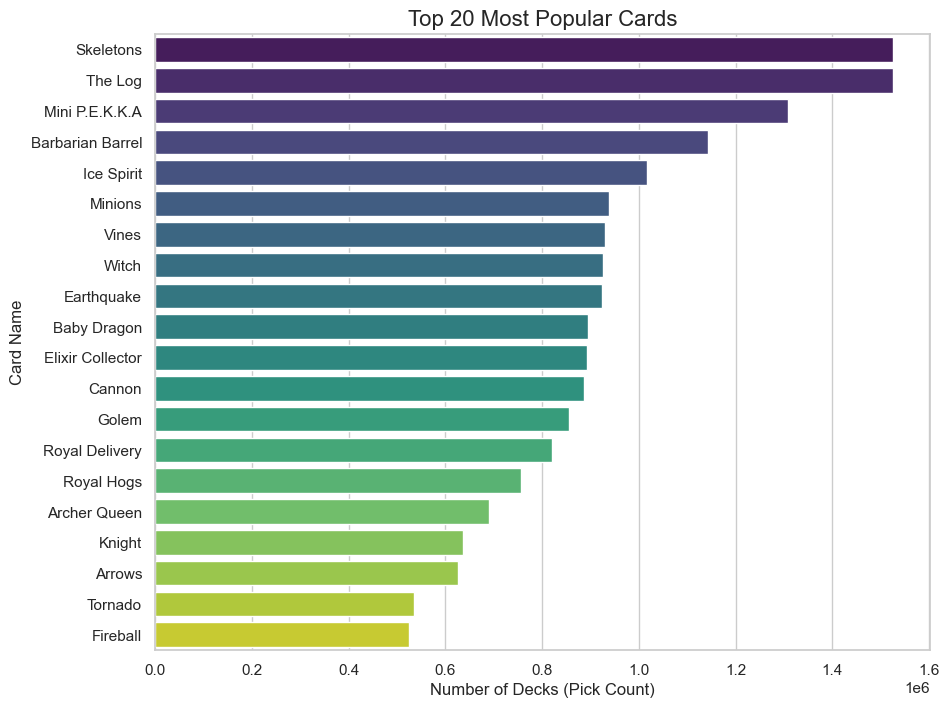

In [4]:
if not df_exploded.empty:
    plt.figure(figsize=(10, 8))
    pick_rates = df_exploded['card_name'].value_counts().nlargest(20)
    
    sns.barplot(x=pick_rates.values, y=pick_rates.index, palette='viridis', orient='h')
    plt.title('Top 20 Most Popular Cards', fontsize=16)
    plt.xlabel('Number of Decks (Pick Count)', fontsize=12)
    plt.ylabel('Card Name', fontsize=12)
    plt.show()
else:
    print("Skipping Plot 1: df_exploded is empty.")


## Plot 2: Player Performance by Archetype (Box Plot)
This box plot shows the distribution of player trophies for each main archetype. This helps us understand if certain archetypes are more common at different trophy ranges or if some have a wider skill distribution.

C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\3770964030.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


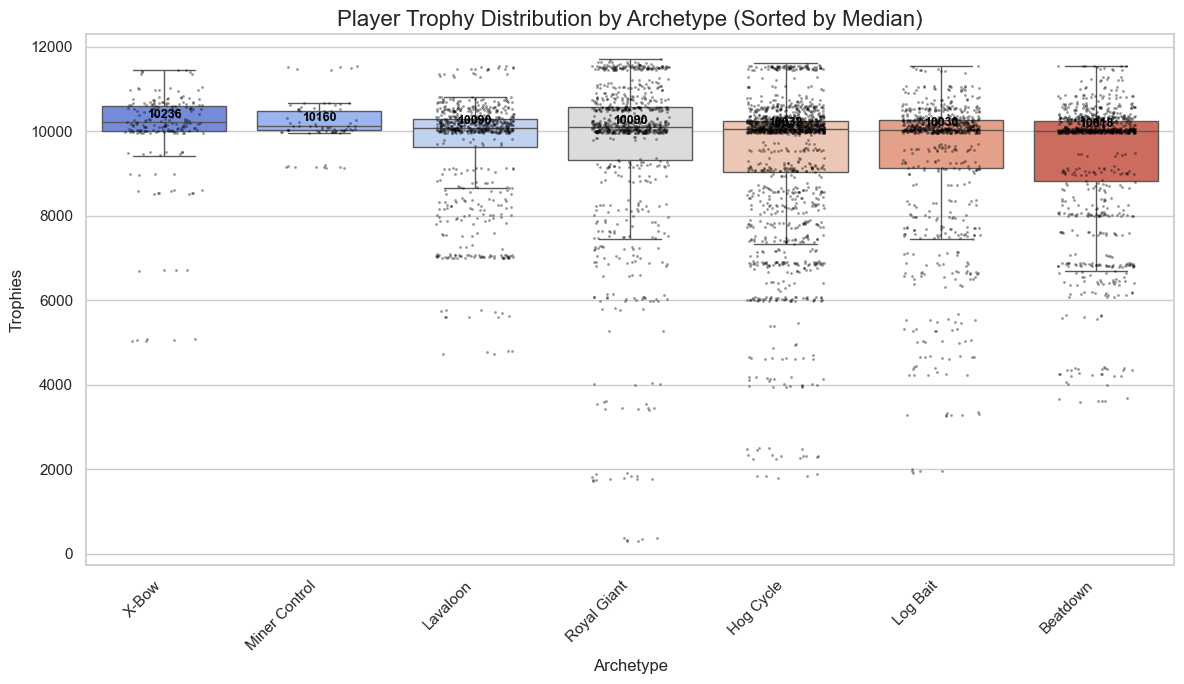

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

MAX_POINTS = 5000  # total points to show in the scatter layer

if 'archetype' in df_prep.columns:
    plt.figure(figsize=(12, 7))
    
    # Normalize names
    df_prep['archetype'] = df_prep['archetype'].astype(str).str.strip().str.title()
    
    # Filter valid data
    df_plot_trophies = df_prep[
        (~df_prep['archetype'].isin(['Unknown', 'Nan'])) &
        (df_prep['trophies'] > 0)
    ].copy()
    
    # Add small jitter to make overlapping values visible
    df_plot_trophies['trophies_jitter'] = (
        df_plot_trophies['trophies'] +
        np.random.uniform(-50, 50, len(df_plot_trophies))
    )

    # Sort archetypes by median trophy value
    order = (
        df_plot_trophies.groupby('archetype')['trophies']
        .median()
        .sort_values(ascending=False)
        .index
    )

    # --- Boxplot (fast) ---
    sns.boxplot(
        data=df_plot_trophies,
        x='archetype',
        y='trophies_jitter',
        order=order,
        palette='coolwarm',
        fliersize=0  # hide outlier markers for cleaner look
    )

    # --- SAMPLE for scatter layer to avoid millions of points ---
    if len(df_plot_trophies) > MAX_POINTS:
        df_scatter = df_plot_trophies.sample(MAX_POINTS, random_state=42)
    else:
        df_scatter = df_plot_trophies

    # --- Stripplot (cheaper than swarmplot) ---
    sns.stripplot(
        data=df_scatter,
        x='archetype',
        y='trophies_jitter',
        order=order,
        color='black',
        alpha=0.4,
        size=2,
        jitter=0.25
    )

    # --- Add median labels ---
    medians = df_plot_trophies.groupby('archetype')['trophies'].median()
    for i, arch in enumerate(order):
        median_val = medians[arch]
        plt.text(
            i,
            median_val + 20,
            f"{int(median_val)}",
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold',
            color='black'
        )

    plt.title('Player Trophy Distribution by Archetype (Sorted by Median)', fontsize=16)
    plt.xlabel('Archetype', fontsize=12)
    plt.ylabel('Trophies', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

else:
    print("Skipping Plot: 'archetype' column not created.")


## Plot 3: Win Rate Over Time - Attack vs. Defense (Line Plot)
This line chart compares the daily average win rate for 'Attack' modes (like Ladder, Challenges) versus 'Defense' modes (like Clan Wars, Friendlies) using the `match_history.csv` data.


In [53]:
# Ensure df_match_filtered is defined
if 'df_match_filtered' not in globals():
    df_match_filtered = pd.DataFrame()

if not df_match_filtered.empty:
    plt.figure(figsize=(12, 7))

    # Ensure datetime
    df_match_filtered['battleTime'] = pd.to_datetime(df_match_filtered['battleTime'])

    # Resample win rate per day per mode
    df_time_series = (
        df_match_filtered
        .set_index('battleTime')
        .groupby('mode_type')['winner_binary']
        .resample('D')
        .mean()
        .reset_index()
    )

    # Fill missing days to keep continuous lines
    df_time_series = (
        df_time_series
        .groupby('mode_type')
        .apply(lambda g: g.set_index('battleTime').asfreq('D').fillna(method='ffill'))
        .drop(columns='mode_type', errors='ignore')
        .reset_index()
    )

    # Optional: add a 3-day rolling average to smooth trends
    df_time_series['winrate_smooth'] = (
        df_time_series.groupby('mode_type')['winner_binary']
        .transform(lambda x: x.rolling(3, min_periods=1).mean())
    )

    # Plot
    sns.lineplot(
        data=df_time_series,
        x='battleTime',
        y='winrate_smooth',
        hue='mode_type',
        palette={'Attack': 'red', 'Defense': 'blue'},
        marker='o'
    )

    plt.title('Win Rate Over Time (Attack vs. Defense Modes)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Average Win Rate (Player)', fontsize=12)
    plt.legend(title='Mode Type')
    plt.tight_layout()
    plt.show()

else:
    print("Skipping Plot 3: Processed match history is empty.")

Skipping Plot 3: Processed match history is empty.


## Plot 4: Troop Win Rate by Archetype (Heatmap)
This heatmap visualizes the average win rate (`winner_flag`) for decks containing a specific troop, grouped by that deck's archetype. This helps identify which troops are most effective in which strategies.

In [10]:
# 1. Build a compact mapping: one archetype per tag
if 'tag' in df_prep.columns and 'archetype' in df_prep.columns:
    df_arch = (
        df_prep[['tag', 'archetype']]
        .dropna(subset=['tag'])         # drop bad tags
        .drop_duplicates('tag')         # KEEP ONLY ONE ROW PER TAG
    )

    # Optional: compress memory a bit
    df_arch['archetype'] = df_arch['archetype'].astype('category')

    print(f"Archetype mapping shape: {df_arch.shape}")  # sanity check

    # 2. Merge this small mapping into df_exploded (m:1 join)
    df_exploded = df_exploded.merge(
        df_arch,
        on='tag',
        how='left',
        validate='m:1'   # many rows in df_exploded, 1 per tag in df_arch
    )

    print("✅ Archetype column successfully added to df_exploded.")

else:
    print("⚠️ Missing 'tag' or 'archetype' column in df_prep.")


Archetype mapping shape: (1173, 2)
✅ Archetype column successfully added to df_exploded.


In [14]:
import ast

# 1. Start from df_prep and build a fresh exploded table
df_exploded = df_prep[['tag', 'winner_flag', 'cards']].copy()

df_exploded['cards_list'] = df_exploded['cards'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else []
)

df_exploded = df_exploded.explode('cards_list').rename(columns={'cards_list': 'card_name'})
df_exploded['winner_flag'] = pd.to_numeric(df_exploded['winner_flag'], errors='coerce').fillna(0)

print("Exploded shape:", df_exploded.shape)
print("Exploded columns:", df_exploded.columns.tolist())

# 2. Build a compact tag → archetype mapping
if 'tag' in df_prep.columns and 'archetype' in df_prep.columns:
    df_arch = (
        df_prep[['tag', 'archetype']]
        .dropna(subset=['tag'])
        .drop_duplicates('tag')
    )
    df_arch['archetype'] = df_arch['archetype'].astype('category')

    print("Archetype mapping shape:", df_arch.shape)

    # 3. Merge (many-to-one) into exploded
    df_exploded = df_exploded.merge(
        df_arch,
        on='tag',
        how='left',
        validate='m:1'
    )

    print("✅ Archetype column successfully added to df_exploded.")
    print("Final columns:", df_exploded.columns.tolist())
else:
    print("⚠️ Missing 'tag' or 'archetype' in df_prep")


Exploded shape: (343251, 4)
Exploded columns: ['tag', 'winner_flag', 'cards', 'card_name']
Archetype mapping shape: (1173, 2)
✅ Archetype column successfully added to df_exploded.
Final columns: ['tag', 'winner_flag', 'cards', 'card_name', 'archetype']


In [15]:
print(df_exploded.shape)
print(df_exploded[['card_name', 'archetype']].head())

print(df_exploded['archetype'].value_counts().head())
print(
    df_exploded.groupby('archetype')['winner_flag']
    .mean()
    .sort_values(ascending=False)
    .head()
)


(343251, 5)
     card_name    archetype
0  Royal Giant  Royal Giant
1  Royal Ghost  Royal Giant
2    Skeletons  Royal Giant
3    Fisherman  Royal Giant
4       Hunter  Royal Giant
archetype
Unknown        139320
Hog Cycle       59272
Beatdown        38850
Royal Giant     34104
Log Bait        32960
Name: count, dtype: int64
archetype
Beatdown         0.626692
Royal Giant      0.622332
Miner Control    0.604905
Unknown          0.599167
Lavaloon         0.591615
Name: winner_flag, dtype: float64


C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\3029240890.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_exploded.groupby('archetype')['winner_flag']


C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\1673934525.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  win_rate_pivot = df_troops.pivot_table(


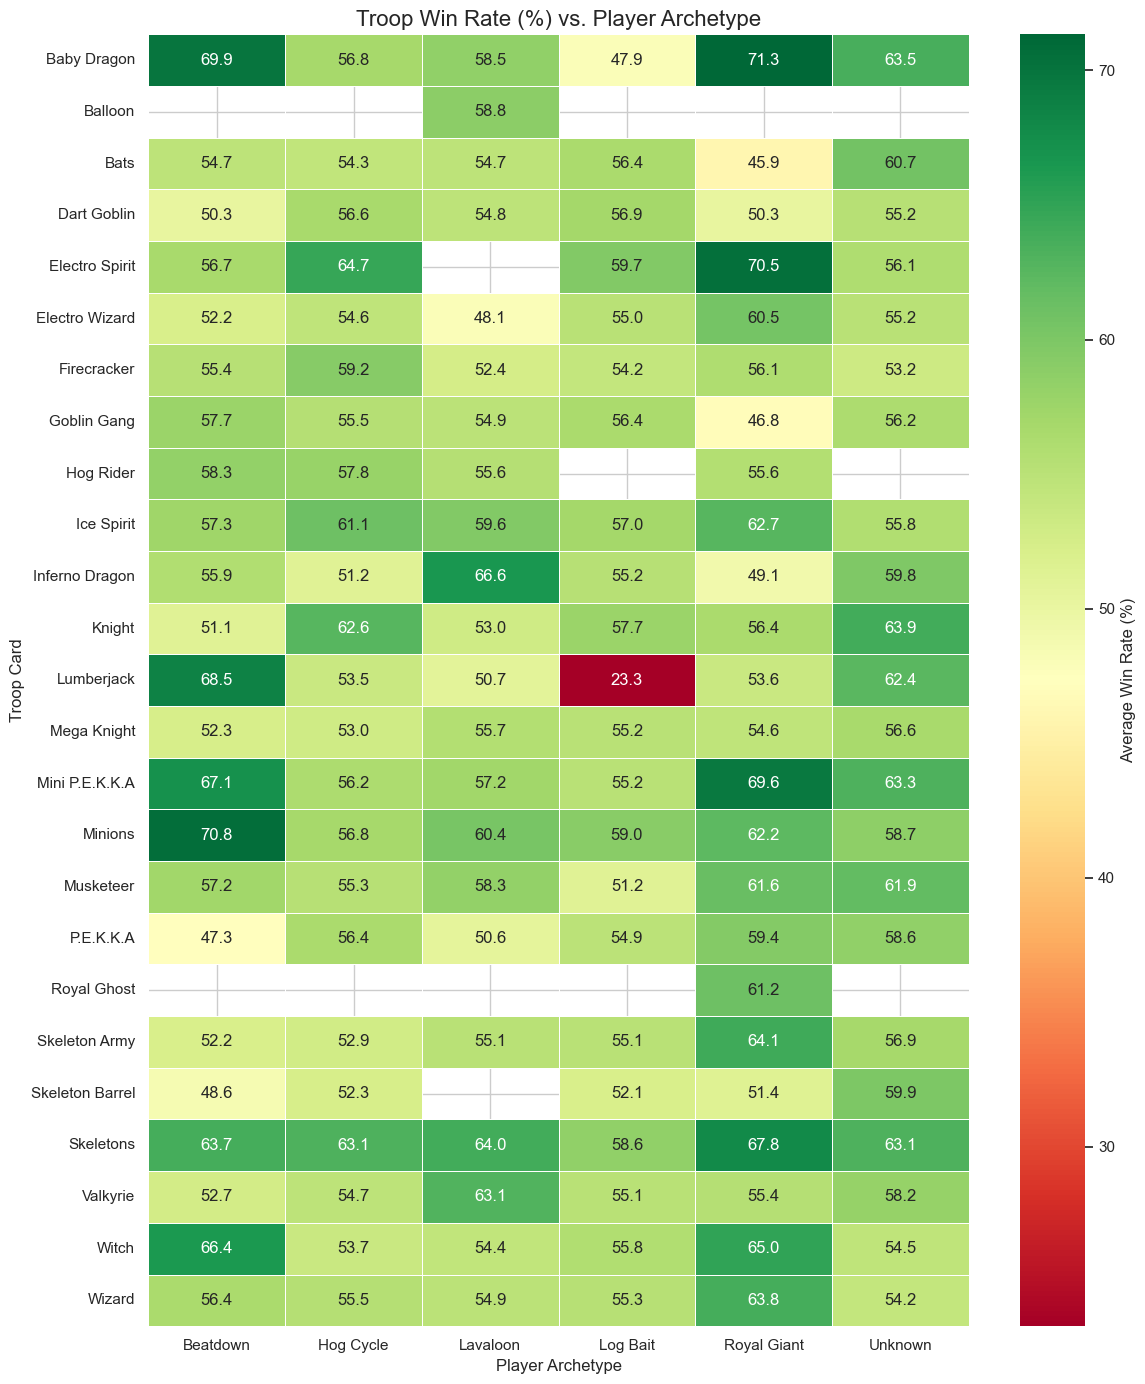

In [16]:
import re

if not df_exploded.empty and 'archetype' in df_exploded.columns and not df_cards.empty:
    try:
        # --- 1️⃣ Clean card names for safer joins ---
        def clean_name(name):
            if isinstance(name, str):
                return re.sub(r'[^a-z0-9 ]', '', name.lower().strip())
            return ''
        
        df_cards['card_name_clean'] = df_cards['card_name'].apply(clean_name)
        df_exploded['card_name_clean'] = df_exploded['card_name'].apply(clean_name)
        

        # --- 2️⃣ Map card types ---
        card_types = (
            df_cards[['card_name_clean', 'card_type']]
            .drop_duplicates()
            .set_index('card_name_clean')
        )
        df_exploded['card_type'] = df_exploded['card_name_clean'].map(card_types['card_type']).fillna('Unknown')

        # --- 3️⃣ Filter to troops only ---
        df_troops = df_exploded[df_exploded['card_type'].str.lower() == 'troop']

        if not df_troops.empty:
            # --- 4️⃣ Pivot for win rate ---
            win_rate_pivot = df_troops.pivot_table(
                index='card_name',
                columns='archetype',
                values='winner_flag',
                aggfunc='mean'
            )

            # --- 5️⃣ Keep top cards/archetypes only for clarity ---
            common_cards = df_troops['card_name'].value_counts().nlargest(25).index
            common_archetypes = df_troops['archetype'].value_counts().nlargest(6).index

            win_rate_pivot_filtered = win_rate_pivot.loc[
                win_rate_pivot.index.isin(common_cards),
                win_rate_pivot.columns.isin(common_archetypes)
            ]

            if win_rate_pivot_filtered.empty:
                print("No data available for heatmap after filtering.")
            else:
                # --- 6️⃣ Convert to % for readability ---
                win_rate_pivot_filtered = win_rate_pivot_filtered * 100

                # --- 7️⃣ Plot heatmap ---
                plt.figure(figsize=(12, 14))
                sns.heatmap(
                    win_rate_pivot_filtered,
                    annot=True,
                    fmt=".1f",  # e.g., 63.5 (%)
                    cmap="RdYlGn",  # Better contrast for win rates
                    linewidth=0.5,
                    cbar_kws={'label': 'Average Win Rate (%)'}
                )

                plt.title('Troop Win Rate (%) vs. Player Archetype', fontsize=16)
                plt.xlabel('Player Archetype', fontsize=12)
                plt.ylabel('Troop Card', fontsize=12)
                plt.tight_layout()
                plt.show()

        else:
            print("Skipping Plot 4: No troop data found after filtering.")

    except Exception as e:
        print(f"Error generating heatmap: {e}")

else:
    print("Skipping Plot 4: Missing necessary data for heatmap.")

C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\2139238818.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  win_rate_pivot = df_troops.pivot_table(
C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\2139238818.py:84: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


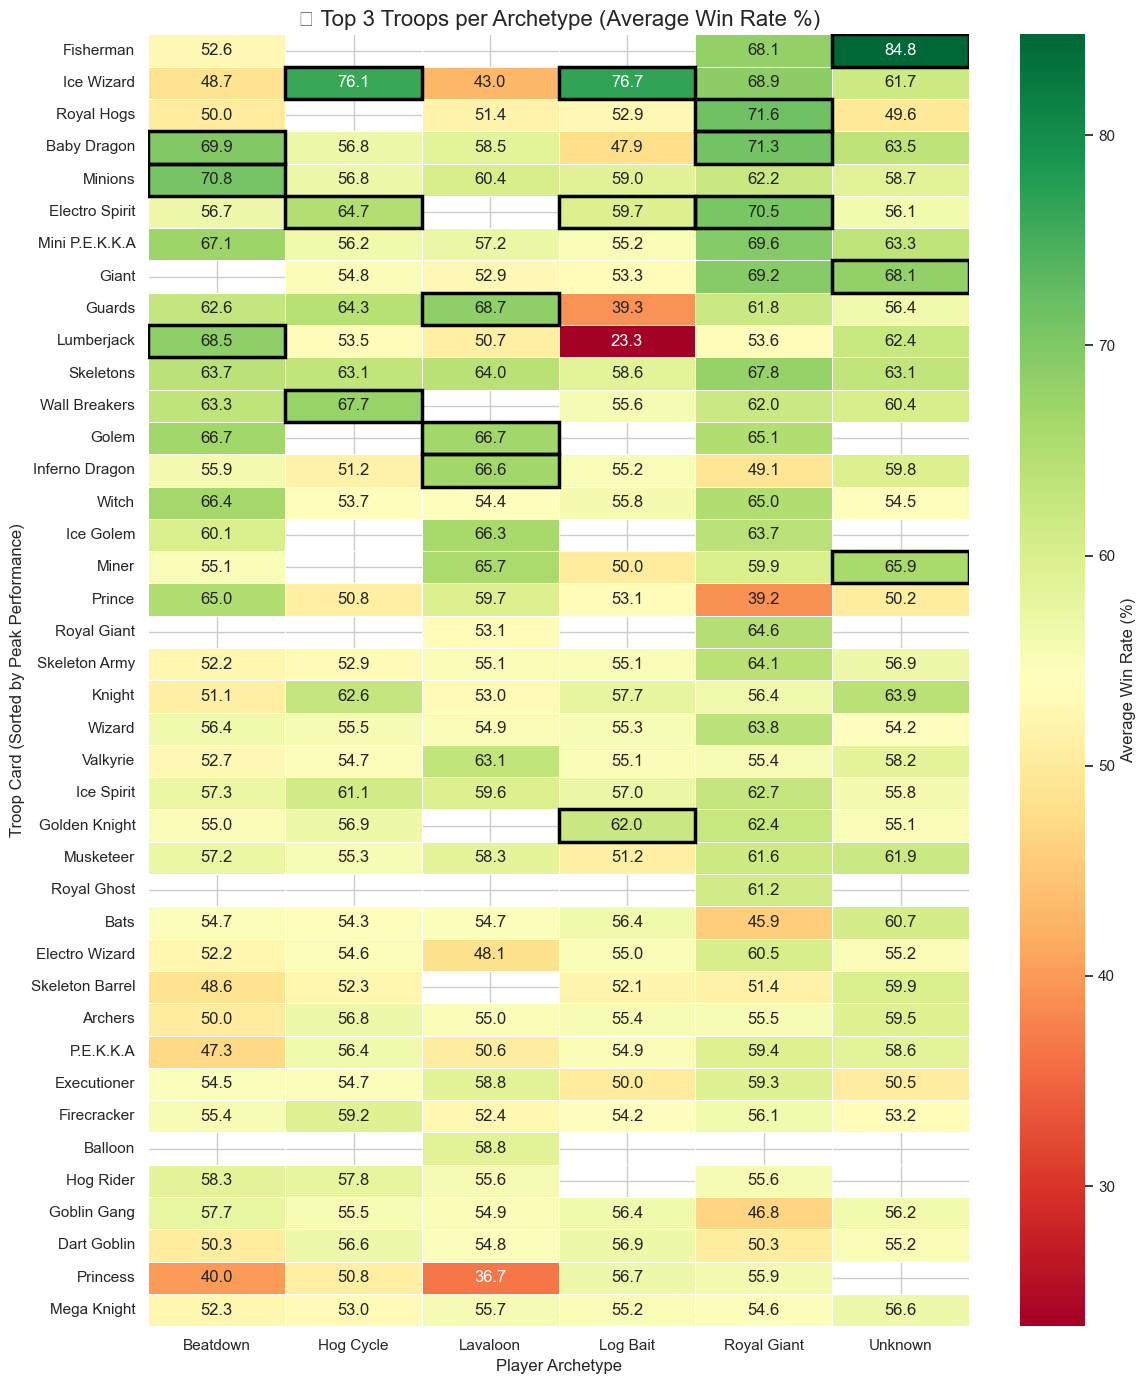

In [17]:
if not df_exploded.empty and 'archetype' in df_exploded.columns and not df_cards.empty:
    try:
        # --- 1️⃣ Clean card names consistently ---
        def clean_name(name):
            if isinstance(name, str):
                return re.sub(r'[^a-z0-9 ]', '', name.lower().strip())
            return ''
        
        df_cards['card_name_clean'] = df_cards['card_name'].apply(clean_name)
        df_exploded['card_name_clean'] = df_exploded['card_name'].apply(clean_name)

        # --- 2️⃣ Map card types ---
        card_types = (
            df_cards[['card_name_clean', 'card_type']]
            .drop_duplicates()
            .set_index('card_name_clean')
        )
        df_exploded['card_type'] = df_exploded['card_name_clean'].map(card_types['card_type']).fillna('Unknown')

        # --- 3️⃣ Filter troops only ---
        df_troops = df_exploded[df_exploded['card_type'].str.lower() == 'troop']

        if not df_troops.empty:
            # --- 4️⃣ Pivot for average win rate ---
            win_rate_pivot = df_troops.pivot_table(
                index='card_name',
                columns='archetype',
                values='winner_flag',
                aggfunc='mean'
            )

            # --- 5️⃣ Limit to top cards/archetypes ---
            common_cards = df_troops['card_name'].value_counts().nlargest(40).index
            common_archetypes = df_troops['archetype'].value_counts().nlargest(6).index
            win_rate_pivot_filtered = win_rate_pivot.loc[
                win_rate_pivot.index.isin(common_cards),
                win_rate_pivot.columns.isin(common_archetypes)
            ] * 100  # convert to %

            if win_rate_pivot_filtered.empty:
                print("No data available for heatmap after filtering.")
            else:
                # --- 6️⃣ Sort by overall performance ---
                card_order = (
                    win_rate_pivot_filtered
                    .max(axis=1)
                    .sort_values(ascending=False)
                    .index
                )
                win_rate_sorted = win_rate_pivot_filtered.loc[card_order]

                # --- 7️⃣ Identify top 3 troops per archetype ---
                top_cells = set()
                for col in win_rate_sorted.columns:
                    top3 = win_rate_sorted[col].nlargest(3).index
                    for idx in top3:
                        top_cells.add((idx, col))

                # --- 8️⃣ Plot heatmap ---
                plt.figure(figsize=(12, 14))
                ax = sns.heatmap(
                    win_rate_sorted,
                    annot=True,
                    fmt=".1f",
                    cmap="RdYlGn",
                    linewidth=0.5,
                    cbar_kws={'label': 'Average Win Rate (%)'}
                )

                # --- 9️⃣ Highlight Top 3 cells with boxes ---
                for i, card in enumerate(win_rate_sorted.index):
                    for j, arch in enumerate(win_rate_sorted.columns):
                        if (card, arch) in top_cells:
                            ax.add_patch(plt.Rectangle(
                                (j, i), 1, 1,
                                fill=False,
                                edgecolor='black',
                                lw=2.5
                            ))

                plt.title('🔥 Top 3 Troops per Archetype (Average Win Rate %)', fontsize=16)
                plt.xlabel('Player Archetype', fontsize=12)
                plt.ylabel('Troop Card (Sorted by Peak Performance)', fontsize=12)
                plt.tight_layout()
                plt.show()

        else:
            print("Skipping Plot 4: No troop data found after filtering.")

    except Exception as e:
        print(f"Error generating heatmap: {e}")

else:
    print("Skipping Plot 4: Missing necessary data for heatmap.")


C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\2456360799.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot_trophies, x='archetype', y='trophies', palette='coolwarm')


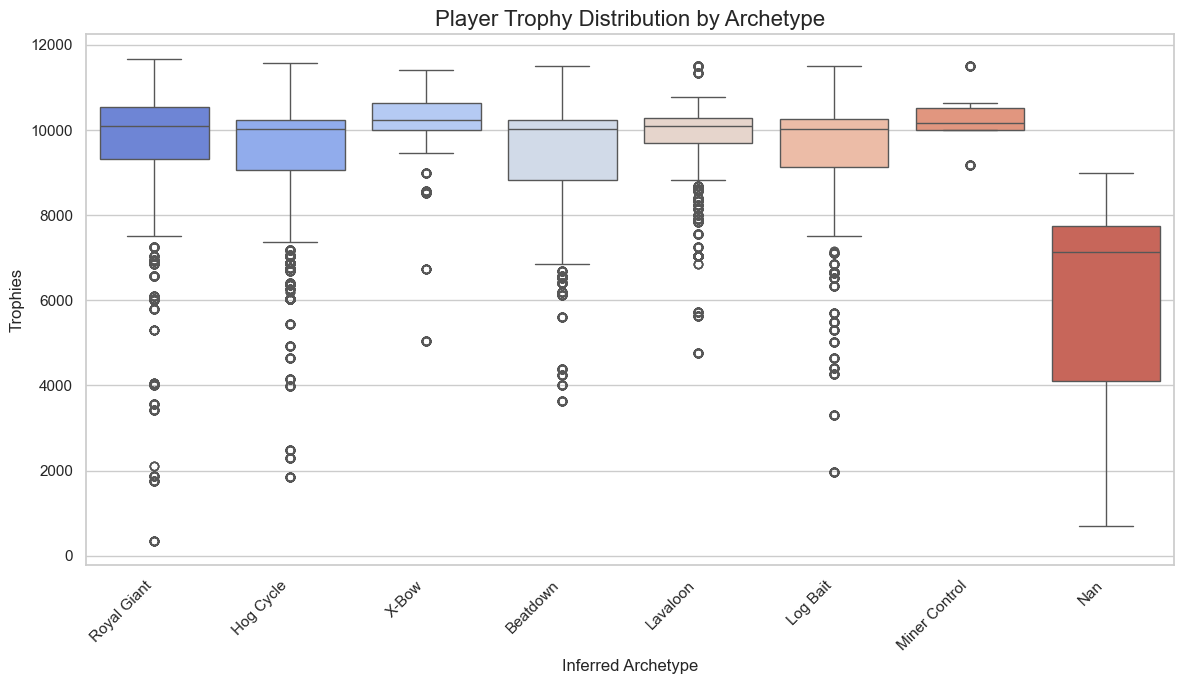

In [18]:
# ## Plot 2: Player Performance by Archetype (Box Plot)

if 'archetype' in df_prep.columns:
    plt.figure(figsize=(12, 7))
    # Filter out 'Unknown' and 'nan' for a cleaner plot
    df_plot_trophies = df_prep[
        (~df_prep['archetype'].isin(['Unknown', 'nan'])) &
        (df_prep['trophies'] > 0)  # Ensure valid trophies
    ]
    
    sns.boxplot(data=df_plot_trophies, x='archetype', y='trophies', palette='coolwarm')
    plt.title('Player Trophy Distribution by Archetype', fontsize=16)
    plt.xlabel('Inferred Archetype', fontsize=12)
    plt.ylabel('Trophies', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Plot 2: 'archetype' column not created.")


C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\3106155831.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


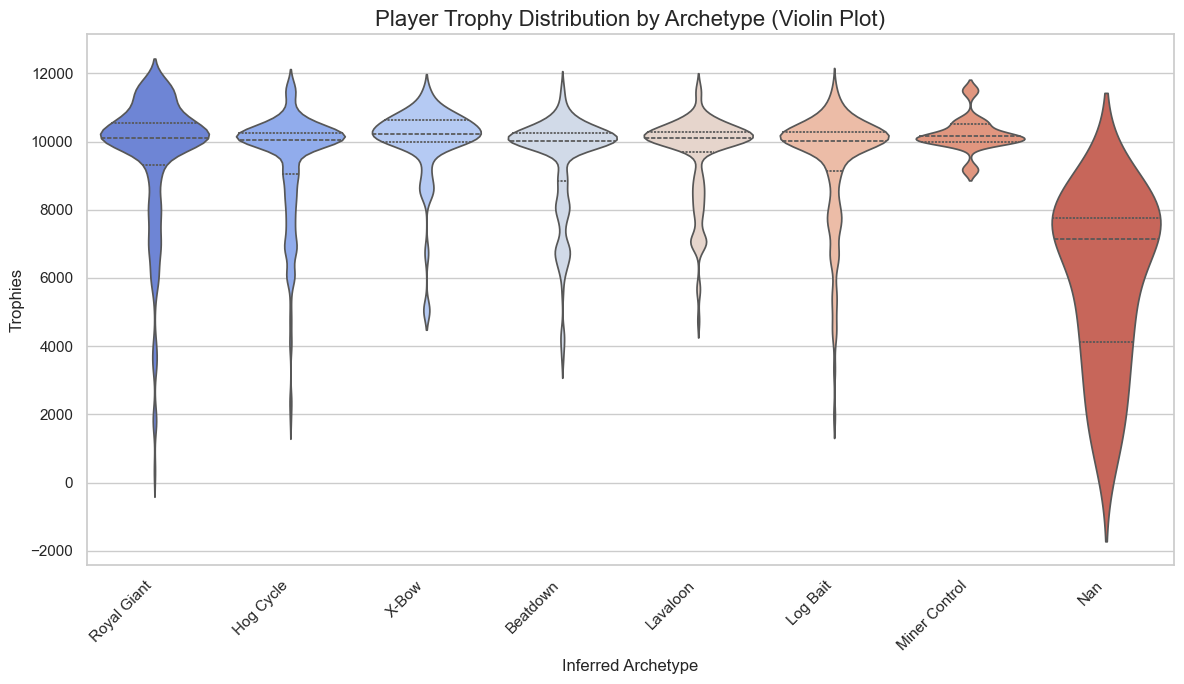

In [19]:
# ## Plot 2: Player Performance by Archetype (Violin Plot)

if 'archetype' in df_prep.columns:
    plt.figure(figsize=(12, 7))
    # Filter out 'Unknown' and 'nan' archetypes for clarity
    df_plot_trophies = df_prep[
        (~df_prep['archetype'].isin(['Unknown', 'nan'])) &
        (df_prep['trophies'] > 0)  # Ensure valid trophies
    ]
    
    sns.violinplot(
        data=df_plot_trophies,
        x='archetype',
        y='trophies',
        palette='coolwarm',
        inner='quartile'  # Shows median and quartiles inside each violin
    )
    
    plt.title('Player Trophy Distribution by Archetype (Violin Plot)', fontsize=16)
    plt.xlabel('Inferred Archetype', fontsize=12)
    plt.ylabel('Trophies', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Plot 2: 'archetype' column not created.")


C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\922006955.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


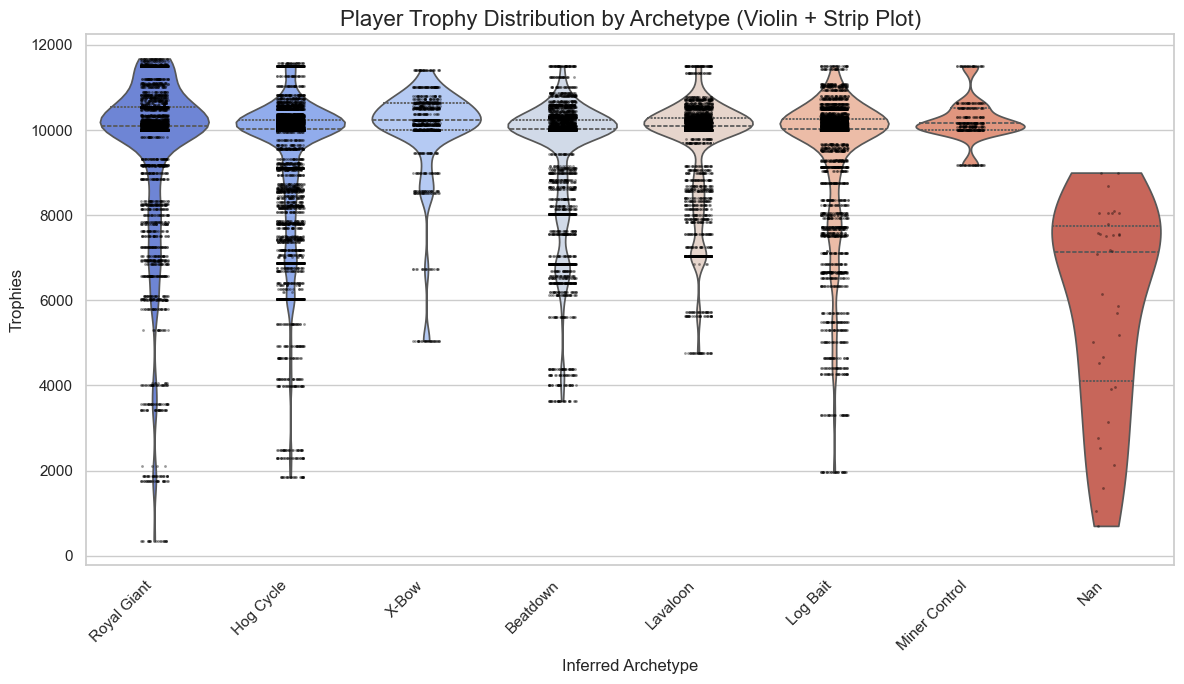

In [20]:
# ## Plot 2: Player Performance by Archetype (Violin + Strip Plot for Large Datasets)

if 'archetype' in df_prep.columns:
    plt.figure(figsize=(12, 7))
    
    # Filter out 'Unknown' and 'nan' for a cleaner plot
    df_plot_trophies = df_prep[
        (~df_prep['archetype'].isin(['Unknown', 'nan'])) &
        (df_prep['trophies'] > 0)  # Ensure valid trophies
    ]
    
    # Violin plot (smooth distribution)
    sns.violinplot(
        data=df_plot_trophies,
        x='archetype',
        y='trophies',
        palette='coolwarm',
        inner='quartile',
        cut=0
    )
    
    # Strip plot overlay (fast for large datasets)
    sns.stripplot(
        data=df_plot_trophies,
        x='archetype',
        y='trophies',
        color='black',
        size=2,
        alpha=0.4,
        jitter=True  # Adds slight horizontal scatter for readability
    )
    
    plt.title('Player Trophy Distribution by Archetype (Violin + Strip Plot)', fontsize=16)
    plt.xlabel('Inferred Archetype', fontsize=12)
    plt.ylabel('Trophies', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Plot 2: 'archetype' column not created.")


## Generate Elixir Boxplot

In [21]:
# Define path to preprocessed data (adjust this to your project structure)
DATA_DIR = "../data"
PREPROCESSED_PATH = os.path.join(DATA_DIR, "preprocessed_data.csv")

try:
    df_preprocessed = pd.read_csv(PREPROCESSED_PATH)
    print(f"✅ Loaded preprocessed_data.csv: {df_preprocessed.shape}")
except FileNotFoundError:
    print("❌ File not found. Please ensure 'preprocessed_data.csv' is in the '../data/' directory.")
    raise
except Exception as e:
    print(f"❌ Unexpected error loading file: {e}")
    raise

# Quick look at data
df_preprocessed.head()


✅ Loaded preprocessed_data.csv: (42971, 65)


C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\464824111.py:6: DtypeWarning: Columns (15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df_preprocessed = pd.read_csv(PREPROCESSED_PATH)


,tag,name,trophies,explevel,arena,clan,arena_encoded,cards,averageelixir,avg_elixir,...,game_mode_showdown_friendly,game_mode_teamvsteam,game_mode_teamvsteam_touchdown_draft,game_mode_teamvsteam_tripleelixir_friendly,game_mode_touchdown_clanwar,game_mode_touchdown_draft,game_mode_tournament,game_mode_tripleelixir_friendly,game_mode_tripleelixir_ladder,game_mode_nan
0,#2Q9JG29RL,Sofiane,10504,71,Royal Road,WeNeedBLΘΘD,21,"['Royal Giant', 'Royal Ghost', 'Skeletons', 'F...",3.0,3.0,...,False,False,False,False,False,False,False,False,False,False
1,#2Q9JG29RL,Sofiane,10504,71,Royal Road,WeNeedBLΘΘD,21,"['Royal Giant', 'Royal Ghost', 'Skeletons', 'F...",3.0,3.0,...,False,False,False,False,False,False,False,False,False,False
2,#2Q9JG29RL,Sofiane,10504,71,Royal Road,WeNeedBLΘΘD,21,"['Royal Giant', 'Royal Ghost', 'Skeletons', 'F...",3.0,3.0,...,False,False,False,False,False,False,False,False,False,False
3,#2Q9JG29RL,Sofiane,10504,71,Royal Road,WeNeedBLΘΘD,21,"['Royal Giant', 'Royal Ghost', 'Skeletons', 'F...",3.0,3.0,...,False,False,False,False,False,False,False,False,False,False
4,#2Q9JG29RL,Sofiane,10504,71,Royal Road,WeNeedBLΘΘD,21,"['Royal Giant', 'Royal Ghost', 'Skeletons', 'F...",3.0,3.0,...,False,False,False,False,False,False,False,False,False,False


💧 Average Elixir Usage by Archetype
Compares average elixir cost across different archetypes.

🧩 Reconstructed 'archetype' column from one-hot encoded columns.


C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\2668337553.py:20: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  .idxmax(axis=1)
C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\2668337553.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


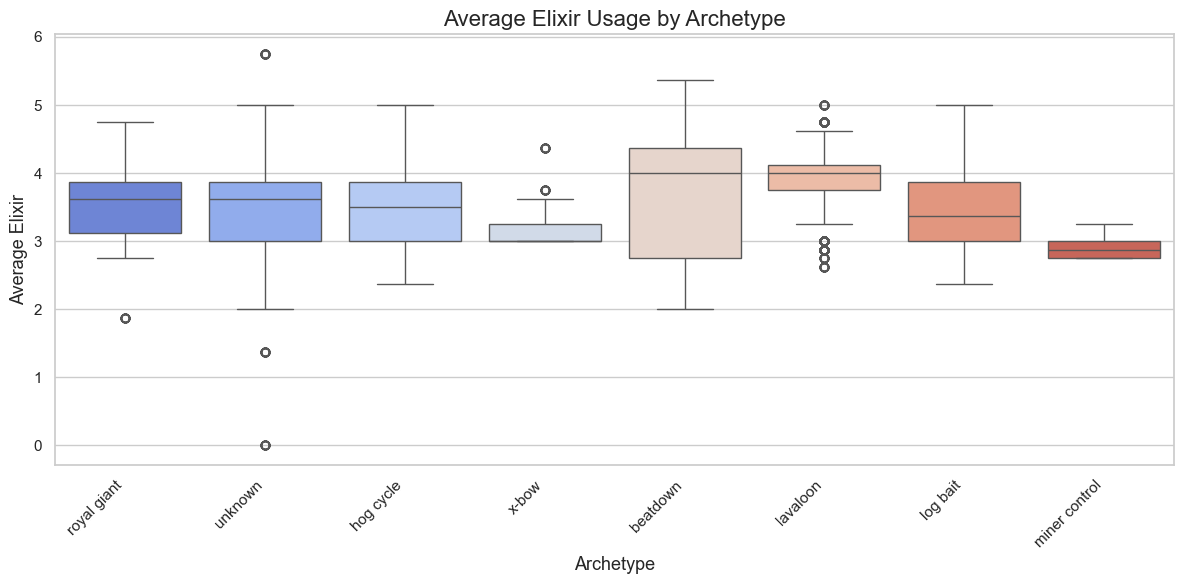

In [22]:
# --- NEW: Elixir Usage by Archetype ---

print("💧 Average Elixir Usage by Archetype")
print("Compares average elixir cost across different archetypes.\n")

try:
    # If 'archetype' column is missing, reconstruct it from one-hot encoded columns
    if 'archetype' not in df_preprocessed.columns:
        archetype_cols = [
            col for col in df_preprocessed.columns
            if col.startswith('player_archetype_') and col != 'player_archetype_nan'
        ]

        if not archetype_cols:
            raise ValueError("No archetype-related columns found in the dataset.")

        # Derive the archetype name from the max one-hot column
        df_preprocessed['archetype'] = (
            df_preprocessed[archetype_cols]
            .idxmax(axis=1)
            .str.replace('player_archetype_', '', regex=False)
        )

        print("🧩 Reconstructed 'archetype' column from one-hot encoded columns.")

    # Filter out invalid archetypes
    df_plot_elixir = df_preprocessed[
        (df_preprocessed['archetype'] != 'Unknown') &
        (df_preprocessed['archetype'] != 'nan')
    ]

    # Plot the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=df_plot_elixir,
        x='archetype',
        y='avg_elixir',
        palette='coolwarm'
    )

    plt.title("Average Elixir Usage by Archetype", fontsize=16)
    plt.xlabel("Archetype", fontsize=13)
    plt.ylabel("Average Elixir", fontsize=13)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Error generating elixir usage plot: {e}")


## 🧠 Model Feature Importance

In [23]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost  # Required to deserialize XGBoost models
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Set Seaborn style
sns.set_theme(style="whitegrid")

print("✅ Libraries loaded and environment configured.")


✅ Libraries loaded and environment configured.


In [24]:
# Define paths (assuming this notebook is inside 'notebooks/')
PROJECT_ROOT = os.path.abspath("..")
MODELS_DIR = os.path.join(PROJECT_ROOT, "models")
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
OUTPUT_DIR = os.path.join(PROJECT_ROOT, "analysis")

# Input files
WIN_SEEKER_MODEL_FILE = os.path.join(MODELS_DIR, "strategy_model_win_seeker.pkl")
LOSS_AVOIDER_MODEL_FILE = os.path.join(MODELS_DIR, "strategy_model_loss_avoider.pkl")
ATTACK_FEATURES_FILE = os.path.join(DATA_DIR, "attack_mode_features.csv")
DEFENSE_FEATURES_FILE = os.path.join(DATA_DIR, "defense_mode_features.csv")

# Output plots
WIN_SEEKER_PLOT_FILE = os.path.join(OUTPUT_DIR, "win_seeker_feature_importance.png")
LOSS_AVOIDER_PLOT_FILE = os.path.join(OUTPUT_DIR, "loss_avoider_feature_importance.png")

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"📁 Models directory: {MODELS_DIR}")
print(f"📁 Data directory:   {DATA_DIR}")
print(f"📁 Output directory: {OUTPUT_DIR}")


📁 Models directory: c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\models
📁 Data directory:   c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\data
📁 Output directory: c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\analysis


In [25]:
try:
    print("🔍 Loading trained models...")
    model_win_seeker = joblib.load(WIN_SEEKER_MODEL_FILE)
    model_loss_avoider = joblib.load(LOSS_AVOIDER_MODEL_FILE)
    print("✅ Models loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Model file not found: {e.filename}")
    print("Please verify your 'models/' directory contains the required .pkl files.")
    raise
except Exception as e:
    print(f"❌ Unexpected error loading models: {e}")
    raise


🔍 Loading trained models...
✅ Models loaded successfully.


In [26]:
try:
    print("📊 Loading feature datasets...")
    df_attack = pd.read_csv(ATTACK_FEATURES_FILE)
    df_defense = pd.read_csv(DEFENSE_FEATURES_FILE)
    
    # Combine both datasets
    df_features = pd.concat([df_attack, df_defense], ignore_index=True)
    X = df_features.drop(columns=['player_tag'], errors='ignore')
    feature_names = X.columns.tolist()

    print(f"✅ Loaded {len(feature_names)} features for analysis.")
except FileNotFoundError as e:
    print(f"❌ Missing feature file: {e.filename}")
    raise
except Exception as e:
    print(f"❌ Error reading feature files: {e}")
    raise

# Preview features
X.head()


📊 Loading feature datasets...
✅ Loaded 43 features for analysis.


C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\1628645746.py:3: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_attack = pd.read_csv(ATTACK_FEATURES_FILE)


,mode,avg_elixir,total_dps,avg_dps,defense_strength,offense_strength,spell_ratio,troop_ratio,building_ratio,avg_hitpoints,...,player_archetype_hog cycle,player_archetype_lavaloon,player_archetype_log bait,player_archetype_miner control,player_archetype_royal giant,player_archetype_unknown,player_archetype_x-bow,player_archetype_nan,opponent_archetype_unknown,opponent_archetype_nan
0,attack,-0.895872,0.560967,0.41262,-0.045535,0.233426,0.25,0.75,0.0,-0.159075,...,0,0,0,0,0,0,0,0,True,0
1,attack,-0.895872,0.560967,0.41262,-0.045535,0.233426,0.25,0.75,0.0,-0.159075,...,0,0,0,0,0,0,0,0,True,0
2,attack,-0.895872,0.560967,0.41262,-0.045535,0.233426,0.25,0.75,0.0,-0.159075,...,0,0,0,0,0,0,0,0,True,0
3,attack,-0.895872,0.560967,0.41262,-0.045535,0.233426,0.25,0.75,0.0,-0.159075,...,0,0,0,0,0,0,0,0,True,0
4,attack,-0.895872,0.560967,0.41262,-0.045535,0.233426,0.25,0.75,0.0,-0.159075,...,0,0,0,0,0,0,0,0,True,0


⚔️ Analyzing 'Win-Seeker' Model Feature Importances...


C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\2272317121.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp_win, x='importance', y='feature', palette='viridis')


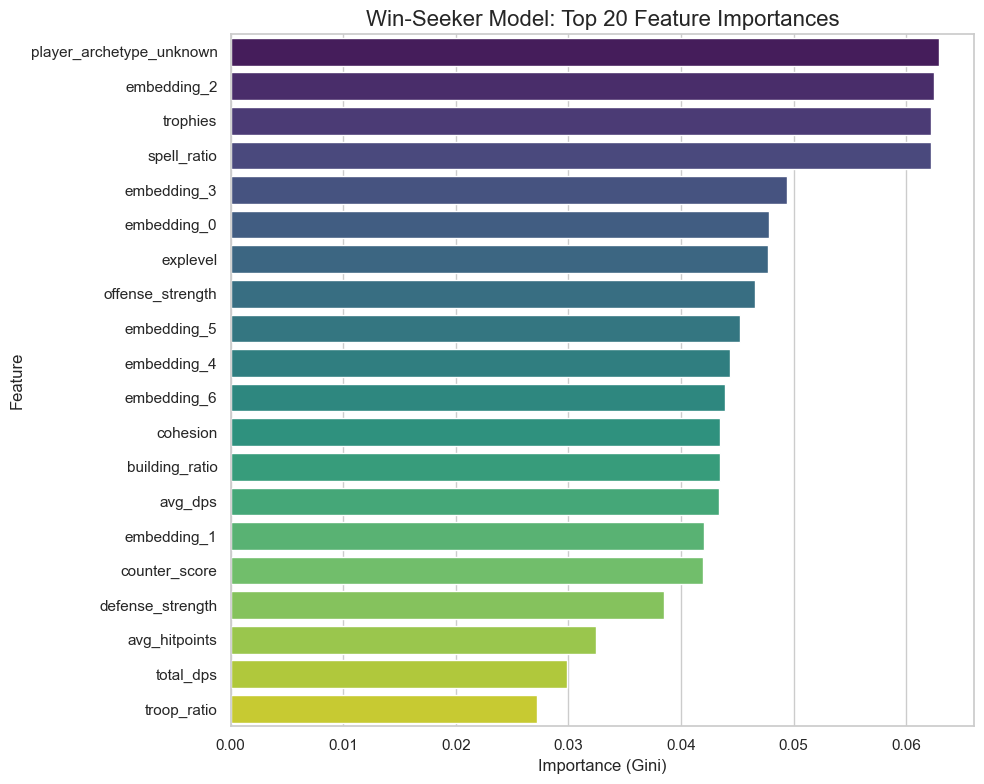

✅ Win-Seeker plot saved to: c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\analysis\win_seeker_feature_importance.png


,feature,importance
38,player_archetype_unknown,0.062887
16,embedding_2,0.062470
30,trophies,0.062243
6,spell_ratio,0.062190
17,embedding_3,0.049439
14,embedding_0,0.047821
31,explevel,0.047711
5,offense_strength,0.046588
19,embedding_5,0.045290
18,embedding_4,0.044362


In [27]:
print("⚔️ Analyzing 'Win-Seeker' Model Feature Importances...")

try:
    importances_win = model_win_seeker.feature_importances_
    df_imp_win = (
        pd.DataFrame({'feature': feature_names, 'importance': importances_win})
        .sort_values(by='importance', ascending=False)
        .head(20)
    )

    plt.figure(figsize=(10, 8))
    sns.barplot(data=df_imp_win, x='importance', y='feature', palette='viridis')
    plt.title('Win-Seeker Model: Top 20 Feature Importances', fontsize=16)
    plt.xlabel('Importance (Gini)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.savefig(WIN_SEEKER_PLOT_FILE)
    plt.show()

    print(f"✅ Win-Seeker plot saved to: {WIN_SEEKER_PLOT_FILE}")
    display(df_imp_win.head(10))

except Exception as e:
    print(f"❌ Error analyzing Win-Seeker model: {e}")


🛡️ Analyzing 'Loss-Avoider' Model Feature Importances...


C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\2276493954.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp_loss, x='importance', y='feature', palette='plasma')


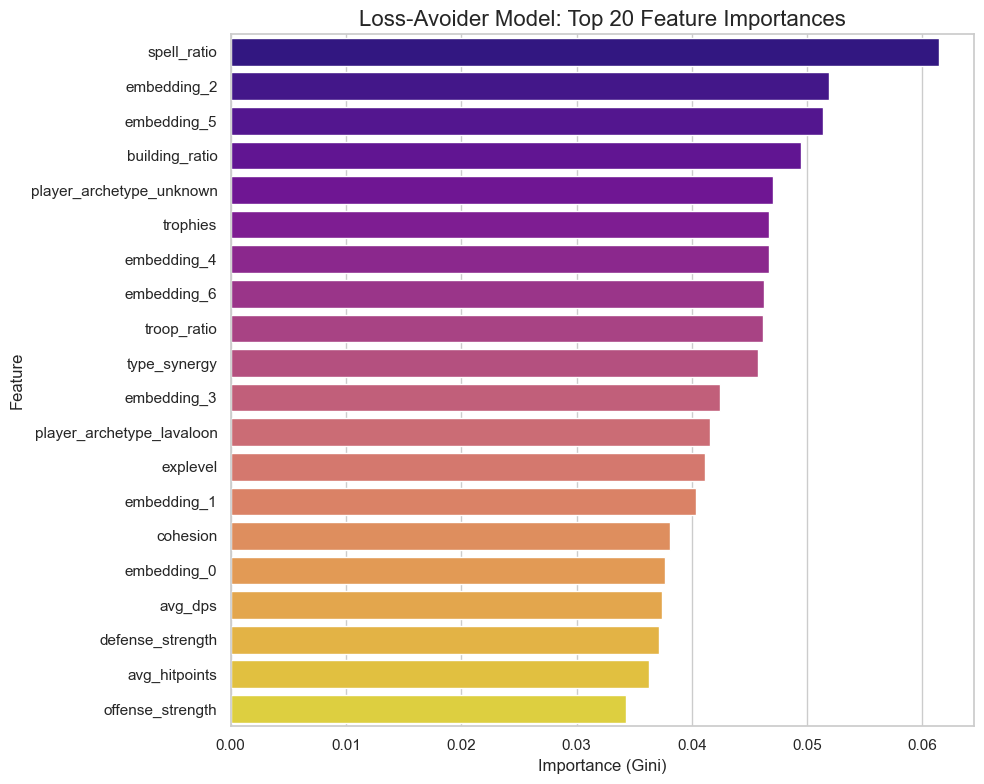

✅ Loss-Avoider plot saved to: c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\analysis\loss_avoider_feature_importance.png


,feature,importance
6,spell_ratio,0.061399
16,embedding_2,0.051914
19,embedding_5,0.051373
8,building_ratio,0.049432
38,player_archetype_unknown,0.047050
30,trophies,0.046700
18,embedding_4,0.046687
20,embedding_6,0.046270
7,troop_ratio,0.046175
11,type_synergy,0.045728


In [28]:
print("🛡️ Analyzing 'Loss-Avoider' Model Feature Importances...")

try:
    importances_loss = model_loss_avoider.feature_importances_
    df_imp_loss = (
        pd.DataFrame({'feature': feature_names, 'importance': importances_loss})
        .sort_values(by='importance', ascending=False)
        .head(20)
    )

    plt.figure(figsize=(10, 8))
    sns.barplot(data=df_imp_loss, x='importance', y='feature', palette='plasma')
    plt.title('Loss-Avoider Model: Top 20 Feature Importances', fontsize=16)
    plt.xlabel('Importance (Gini)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.savefig(LOSS_AVOIDER_PLOT_FILE)
    plt.show()

    print(f"✅ Loss-Avoider plot saved to: {LOSS_AVOIDER_PLOT_FILE}")
    display(df_imp_loss.head(10))

except Exception as e:
    print(f"❌ Error analyzing Loss-Avoider model: {e}")


In [29]:
print("📈 Top 5 Feature Comparison Between Models")

try:
    top_win = df_imp_win.head(5).copy()
    top_loss = df_imp_loss.head(5).copy()

    print("\n🏆 Win-Seeker Top 5 Features:")
    display(top_win)

    print("\n🛡️ Loss-Avoider Top 5 Features:")
    display(top_loss)

except Exception as e:
    print(f"❌ Error generating summary comparison: {e}")


📈 Top 5 Feature Comparison Between Models

🏆 Win-Seeker Top 5 Features:


,feature,importance
38,player_archetype_unknown,0.062887
16,embedding_2,0.062470
30,trophies,0.062243
6,spell_ratio,0.062190
17,embedding_3,0.049439



🛡️ Loss-Avoider Top 5 Features:


,feature,importance
6,spell_ratio,0.061399
16,embedding_2,0.051914
19,embedding_5,0.051373
8,building_ratio,0.049432
38,player_archetype_unknown,0.047050


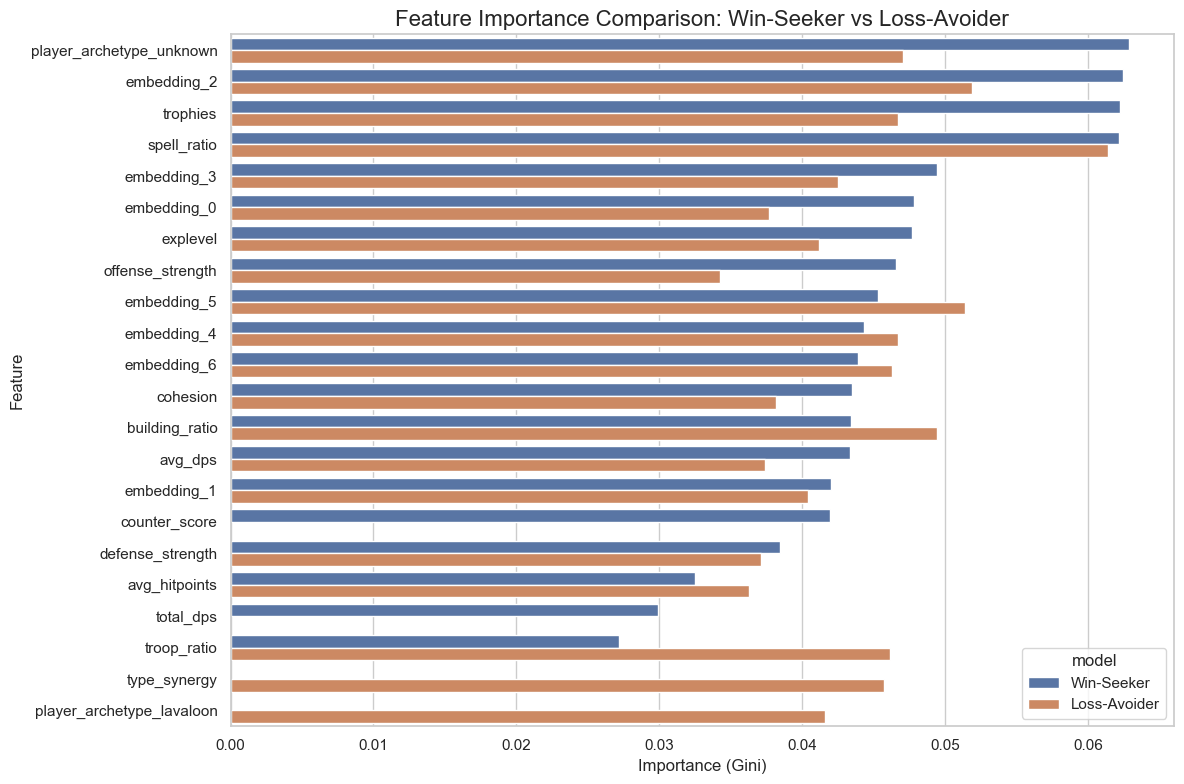

In [30]:
# Optional comparative plot for quick model comparison
try:
    combined = pd.concat([
        df_imp_win.assign(model='Win-Seeker'),
        df_imp_loss.assign(model='Loss-Avoider')
    ])
    
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=combined,
        x='importance',
        y='feature',
        hue='model'
    )
    plt.title('Feature Importance Comparison: Win-Seeker vs Loss-Avoider', fontsize=16)
    plt.xlabel('Importance (Gini)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"❌ Error generating combined importance plot: {e}")


## 📈 Model Performance Validation

In [31]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost  # Required for loading XGBoost-based models
import logging
from typing import Tuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Plot style
sns.set_theme(style="whitegrid")

print("✅ Libraries loaded and environment configured.")


✅ Libraries loaded and environment configured.


In [32]:
# Assume notebook is in 'notebooks/' directory
PROJECT_ROOT = os.path.abspath("..")
MODELS_DIR = os.path.join(PROJECT_ROOT, "models")
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
OUTPUT_DIR = os.path.join(PROJECT_ROOT, "analysis")

# Input files
WIN_SEEKER_MODEL_FILE = os.path.join(MODELS_DIR, "strategy_model_win_seeker.pkl")
LOSS_AVOIDER_MODEL_FILE = os.path.join(MODELS_DIR, "strategy_model_loss_avoider.pkl")
ATTACK_FEATURES_FILE = os.path.join(DATA_DIR, "attack_mode_features.csv")
DEFENSE_FEATURES_FILE = os.path.join(DATA_DIR, "defense_mode_features.csv")
PREPROCESSED_DATA_FILE = os.path.join(DATA_DIR, "preprocessed_data.csv")

# Output file
PROBABILITY_PLOT_FILE = os.path.join(OUTPUT_DIR, "probability_distribution.png")

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"📁 Models directory: {MODELS_DIR}")
print(f"📁 Data directory:   {DATA_DIR}")
print(f"📁 Output directory: {OUTPUT_DIR}")


📁 Models directory: c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\models
📁 Data directory:   c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\data
📁 Output directory: c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\analysis


In [35]:
from typing import Tuple
import pandas as pd
from sklearn.model_selection import train_test_split

def load_and_split_data(
    test_size: float = 0.25,
    random_state: int = 42
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Notebook-safe version:
    - loads attack/defense features + winner_flag
    - fixes length mismatch
    - converts 'mode'
    - cleans object/bool columns (e.g. archetypes)
    - drops NaN labels
    - returns test split only
    """
    logger.info("Loading data sources...")
    try:
        df_attack = pd.read_csv(ATTACK_FEATURES_FILE, low_memory=False)
        df_defense = pd.read_csv(DEFENSE_FEATURES_FILE, low_memory=False)

        # winner_flag as numeric (coerce invalid to NaN)
        df_preprocessed = pd.read_csv(
            PREPROCESSED_DATA_FILE,
            usecols=['winner_flag'],
            low_memory=False
        )
        Y = pd.to_numeric(df_preprocessed['winner_flag'], errors='coerce')

    except FileNotFoundError as e:
        logger.error(f"Error loading data: {e}. Make sure all feature files exist.")
        raise

    # Combine X features
    df_features = pd.concat([df_attack, df_defense], ignore_index=True)
    X = df_features.drop(columns=['player_tag'], errors='ignore')

    logger.info(f"Loaded {len(X)} feature rows and {len(Y)} labels.")

    # Handle length mismatch
    if len(X) != len(Y):
        logger.warning(f"Feature count ({len(X)}) != label count ({len(Y)}) — truncating.")
        min_len = min(len(X), len(Y))
        X = X.head(min_len)
        Y = Y.head(min_len)
        logger.info(f"Trimmed to {min_len} samples for consistency.")

    # Convert 'mode' to numeric
    if 'mode' in X.columns:
        logger.info("Converting 'mode' column to numeric (1=attack, 0=defense)...")
        X['mode'] = X['mode'].apply(
            lambda v: 1 if str(v).strip().lower() == 'attack' else 0
        )
    else:
        logger.error("Critical error: 'mode' column not found in features.")
        raise ValueError("Missing 'mode' column in feature set.")

    # Clean object/bool feature columns (e.g. archetypes)
    object_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
    if object_cols:
        logger.info(f"Cleaning non-numeric cols: {object_cols}")
        for col in object_cols:
            if col.startswith('player_archetype_') or col.startswith('opponent_archetype_'):
                # Treat truthy-ish as 1, everything else as 0
                X[col] = X[col].map(
                    lambda v: 1 if str(v).strip().lower() in ('1', 'true', 'yes') else 0
                )
            else:
                tmp = pd.to_numeric(X[col], errors='coerce')
                if tmp.isna().sum() < len(tmp) * 0.5:
                    X[col] = tmp.fillna(0)
                else:
                    X[col] = X[col].astype('category').cat.codes

    # Drop NaN labels before splitting
    nan_count = Y.isna().sum()
    if nan_count > 0:
        logger.warning(f"Found {nan_count} NaN labels. Dropping those rows.")
        mask = Y.notna()
        X = X[mask].reset_index(drop=True)
        Y = Y[mask].reset_index(drop=True)
        logger.info(f"After dropping NaNs: {len(Y)} samples remain.")

    logger.info(f"Final label distribution:\n{Y.value_counts().to_string()}")

    # Train/test split
    X_train, X_test, Y_train, Y_test = train_test_split(
        X,
        Y,
        test_size=test_size,
        random_state=random_state,
        stratify=Y
    )

    logger.info(
        f"Data split complete. Train size: {len(Y_train)}, "
        f"Test size: {len(Y_test)}"
    )

    return X_test, Y_test


In [36]:
try:
    X_test, Y_test = load_and_split_data()
    print(f"✅ Loaded test dataset: {X_test.shape}, labels: {Y_test.shape}")
except Exception as e:
    print(f"❌ Failed to load or process data: {e}")
    raise


2025-12-10 15:35:36,337 - INFO - Loading data sources...
2025-12-10 15:35:36,816 - INFO - Loaded 55261 feature rows and 42971 labels.
2025-12-10 15:35:36,816 - WARNING - Feature count (55261) != label count (42971) — truncating.
2025-12-10 15:35:36,816 - INFO - Trimmed to 42971 samples for consistency.
2025-12-10 15:35:36,816 - INFO - Converting 'mode' column to numeric (1=attack, 0=defense)...
2025-12-10 15:35:36,839 - INFO - Cleaning non-numeric cols: ['player_archetype_beatdown', 'player_archetype_lavaloon', 'player_archetype_unknown', 'opponent_archetype_unknown']
2025-12-10 15:35:36,896 - WARNING - Found 36 NaN labels. Dropping those rows.
2025-12-10 15:35:36,909 - INFO - After dropping NaNs: 42935 samples remain.
2025-12-10 15:35:36,913 - INFO - Final label distribution:
winner_flag
1.0    25571
0.0    17364
2025-12-10 15:35:36,934 - INFO - Data split complete. Train size: 32201, Test size: 10734


✅ Loaded test dataset: (10734, 43), labels: (10734,)


In [37]:
try:
    print("🔍 Loading trained models...")
    model_win_seeker = joblib.load(WIN_SEEKER_MODEL_FILE)
    model_loss_avoider = joblib.load(LOSS_AVOIDER_MODEL_FILE)
    print("✅ Models loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Model file not found: {e.filename}")
    raise
except Exception as e:
    print(f"❌ Unexpected error loading models: {e}")
    raise


🔍 Loading trained models...
✅ Models loaded successfully.


In [38]:
try:
    print("🧮 Calculating predicted probabilities...")
    probs_win_seeker = model_win_seeker.predict_proba(X_test)[:, 1]
    probs_loss_avoider = model_loss_avoider.predict_proba(X_test)[:, 1]

    df_plot = pd.DataFrame({
        'True Label': Y_test.map({0: 'Lose (0)', 1: 'Win (1)'}),
        'Win-Seeker Prob.': probs_win_seeker,
        'Loss-Avoider Prob.': probs_loss_avoider
    })

    print(f"✅ Probability dataframe created: {df_plot.shape}")
    df_plot.head()

except Exception as e:
    print(f"❌ Error calculating predicted probabilities: {e}")
    raise


🧮 Calculating predicted probabilities...
✅ Probability dataframe created: (10734, 3)


📊 Plotting probability distributions...


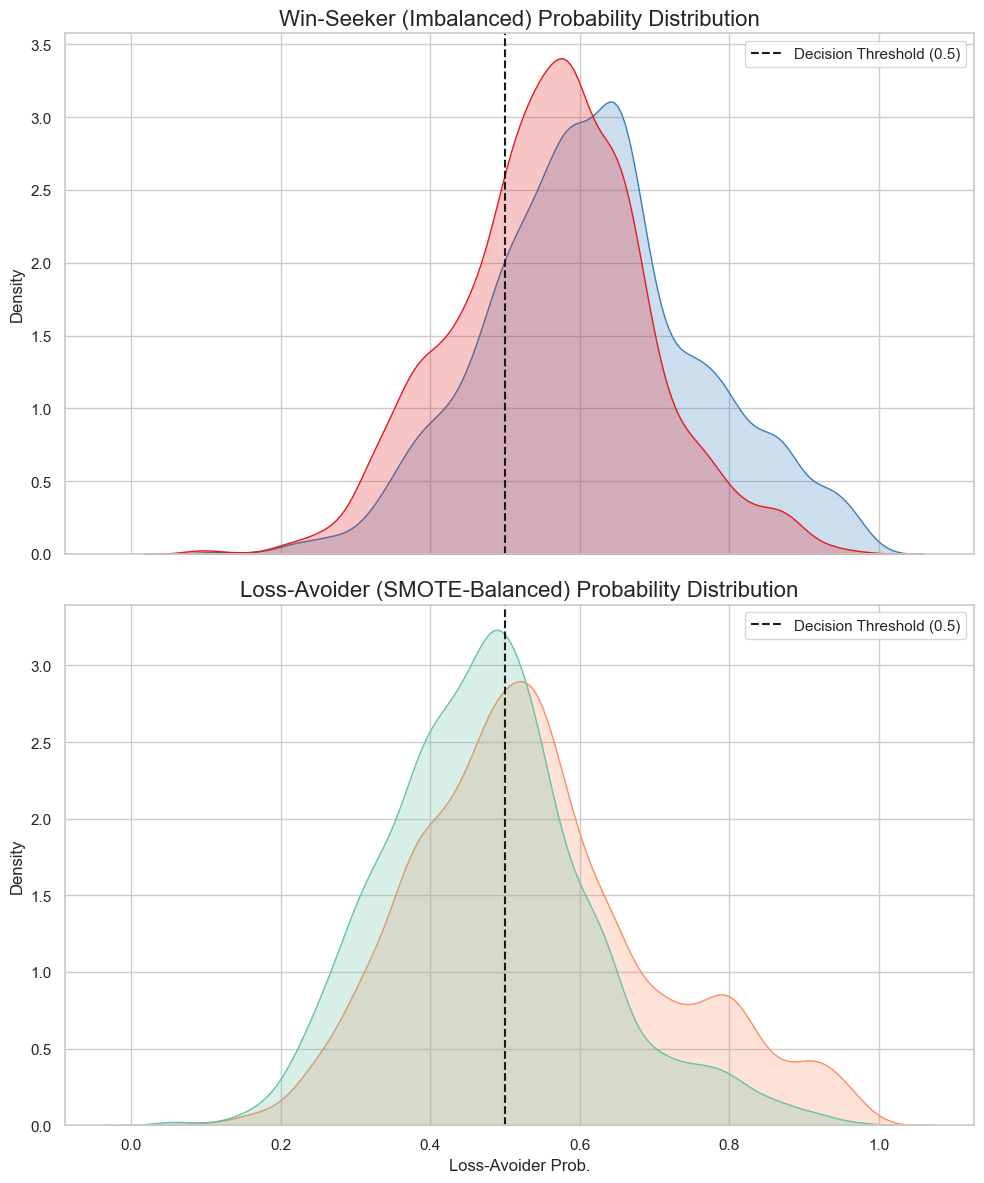

✅ Saved probability distribution plot: c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\analysis\probability_distribution.png


In [39]:
try:
    print("📊 Plotting probability distributions...")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

    # Win-Seeker
    sns.kdeplot(
        data=df_plot, x='Win-Seeker Prob.', hue='True Label',
        fill=True, common_norm=False, palette="Set1", ax=ax1
    )
    ax1.set_title('Win-Seeker (Imbalanced) Probability Distribution', fontsize=16)
    ax1.axvline(0.5, color='k', linestyle='--', label='Decision Threshold (0.5)')
    ax1.legend()

    # Loss-Avoider
    sns.kdeplot(
        data=df_plot, x='Loss-Avoider Prob.', hue='True Label',
        fill=True, common_norm=False, palette="Set2", ax=ax2
    )
    ax2.set_title('Loss-Avoider (SMOTE-Balanced) Probability Distribution', fontsize=16)
    ax2.axvline(0.5, color='k', linestyle='--', label='Decision Threshold (0.5)')
    ax2.legend()

    plt.tight_layout()
    plt.savefig(PROBABILITY_PLOT_FILE)
    plt.show()

    print(f"✅ Saved probability distribution plot: {PROBABILITY_PLOT_FILE}")

except Exception as e:
    print(f"❌ Error generating probability plot: {e}")


📈 Generating ROC curve comparison...


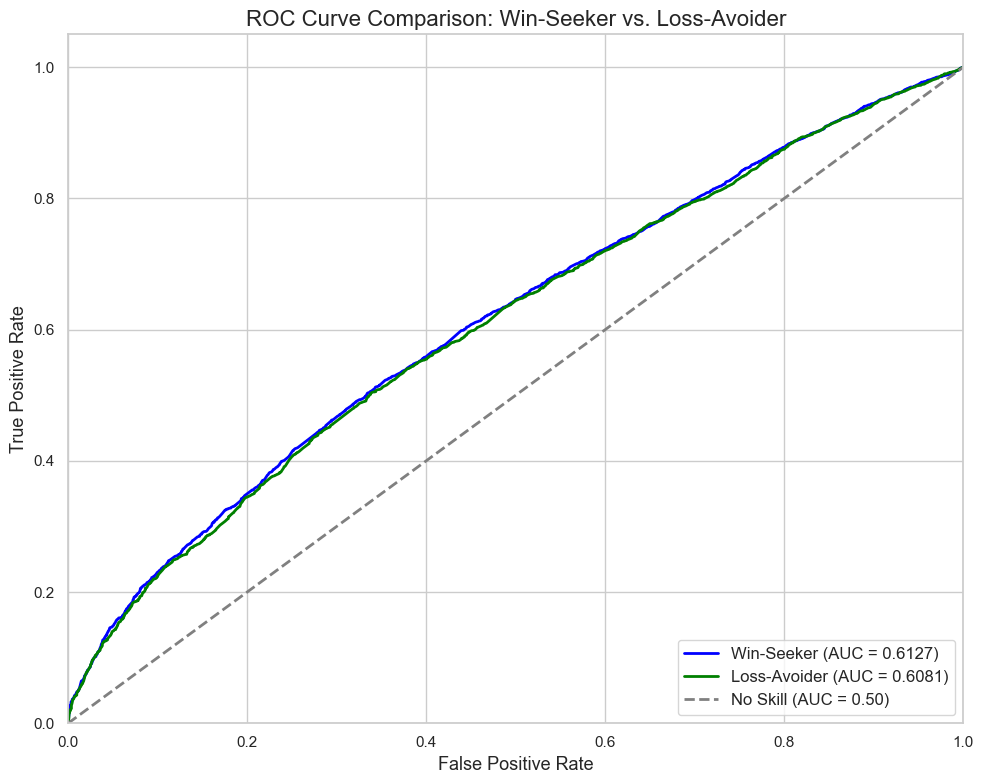

✅ ROC curve plot saved to: c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\analysis\roc_curve_comparison.png


In [40]:
# === ROC Curve Comparison ===
try:
    print("📈 Generating ROC curve comparison...")

    # Compute ROC curve points and AUC for each model
    fpr_ws, tpr_ws, _ = roc_curve(Y_test, probs_win_seeker)
    fpr_la, tpr_la, _ = roc_curve(Y_test, probs_loss_avoider)

    auc_ws = auc(fpr_ws, tpr_ws)
    auc_la = auc(fpr_la, tpr_la)

    # File to save the ROC plot
    ROC_CURVE_PLOT_FILE = os.path.join(OUTPUT_DIR, "roc_curve_comparison.png")

    # Plot
    plt.figure(figsize=(10, 8))
    plt.plot(fpr_ws, tpr_ws, color='blue', lw=2, label=f'Win-Seeker (AUC = {auc_ws:.4f})')
    plt.plot(fpr_la, tpr_la, color='green', lw=2, label=f'Loss-Avoider (AUC = {auc_la:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='No Skill (AUC = 0.50)')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title('ROC Curve Comparison: Win-Seeker vs. Loss-Avoider', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(ROC_CURVE_PLOT_FILE)
    plt.show()

    print(f"✅ ROC curve plot saved to: {ROC_CURVE_PLOT_FILE}")

except Exception as e:
    print(f"❌ Error generating ROC plot: {e}")


In [41]:
print("📊 ROC Summary and Observations")
print(f"- Win-Seeker Model AUC: {auc_ws:.4f}")
print(f"- Loss-Avoider Model AUC: {auc_la:.4f}")

if auc_ws > auc_la:
    print("🏆 The Win-Seeker model demonstrates better overall discrimination power.")
elif auc_la > auc_ws:
    print("🛡️ The Loss-Avoider model performs better in distinguishing wins vs. losses.")
else:
    print("⚖️ Both models show identical ROC performance — interesting equilibrium.")


📊 ROC Summary and Observations
- Win-Seeker Model AUC: 0.6127
- Loss-Avoider Model AUC: 0.6081
🏆 The Win-Seeker model demonstrates better overall discrimination power.


## 🤝 Card Synergy & Top Troops

# Recommended Troop List Generation
This notebook analyzes preprocessed Clash Royale data to identify the most successful troops in **Attack** and **Defense** modes, based on winning decks.
It loads preprocessed match data, filters for winning decks,identifies troop cards, and visualizes the top 15 troops for each mode.


In [42]:
# %%
# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import ast
from collections import Counter
# %%
# --- Configuration ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Set plot style
sns.set_theme(style="whitegrid")


In [43]:
# %%
# --- File Paths ---
PROJECT_ROOT = os.path.dirname(os.path.abspath(''))
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
OUTPUT_DIR = os.path.join(PROJECT_ROOT, "analysis")

# Input files
PREPROCESSED_FILE = os.path.join(DATA_DIR, "preprocessed_data.csv")
CARDS_FILE = os.path.join(DATA_DIR, "cards_data.csv")

# Output plot file
RECOMMENDED_TROOPS_FILE = os.path.join(OUTPUT_DIR, "recommended_troop_lists.png")


In [44]:
# %%
# ----------------------------
# Helper Function
# ----------------------------
def get_mode_type(row):
    """Classifies a row as 'Attack', 'Defense', or 'Other' based on game_mode columns."""
    attack_cols = [
        'game_mode_ladder', 'game_mode_challenge_allcards_eventdeck_noset',
        'game_mode_ranked1v1_newarena', 'game_mode_ranked1v1_newarena2',
        'game_mode_draft_competitive', 'game_mode_showdown_friendly'
    ]
    defense_cols = [
        'game_mode_7xelixir_friendly', 'game_mode_cw_battle_1v1', 'game_mode_cw_duel_1v1',
        'game_mode_clanwar_boatbattle', 'game_mode_duel_1v1_friendly', 'game_mode_friendly',
        'game_mode_teamvsteam', 'game_mode_teamvsteam_tripleelixir_friendly',
        'game_mode_touchdown_draft'
    ]
    
    for col in attack_cols:
        if col in row and row[col] == 1:
            return 'Attack'
            
    for col in defense_cols:
        if col in row and row[col] == 1:
            return 'Defense'
            
    return 'Other'

# %%
# --- Load Data ---
try:
    logger.info(f"Loading {PREPROCESSED_FILE}...")
    df = pd.read_csv(PREPROCESSED_FILE)

    logger.info(f"Loading {CARDS_FILE} to filter for troops...")
    df_cards = pd.read_csv(CARDS_FILE, usecols=['card_name', 'card_type'])

    troop_cards = set(df_cards[df_cards['card_type'] == 'Troop']['card_name'])
    logger.info(f"Found {len(troop_cards)} unique troops.")

except FileNotFoundError as e:
    logger.error(f"ERROR: File not found. Missing file: {e.filename}")
    raise
except Exception as e:
    logger.error(f"Unexpected error during loading: {e}", exc_info=True)
    raise


2025-12-10 15:36:08,738 - INFO - Loading c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\data\preprocessed_data.csv...
C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\3705679646.py:33: DtypeWarning: Columns (15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PREPROCESSED_FILE)
2025-12-10 15:36:09,037 - INFO - Loading c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\data\cards_data.csv to filter for troops...
2025-12-10 15:36:09,042 - INFO - Found 98 unique troops.


2025-12-10 15:36:12,784 - INFO - Parsing 'cards' column and determining modes...


2025-12-10 15:36:14,265 - INFO - Filtered to 25571 winning decks.
2025-12-10 15:36:14,997 - INFO - Top Attack Troops:
       Troop  Frequency
0  Skeletons       6058
1     Knight       4442
2  Hog Rider       3628
2025-12-10 15:36:15,005 - INFO - Top Defense Troops:
         Troop  Frequency
0       Knight       1389
1    Skeletons       1286
2  Firecracker       1214
2025-12-10 15:36:15,006 - INFO - Generating plot... saving to c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\analysis\recommended_troop_lists.png
C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\736012052.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_attack_troops, x='Frequency', y='Troop', ax=ax1, palette='Reds_r')
C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_5024\736012052.py:52: FutureWarning: 

Passing `palette` w

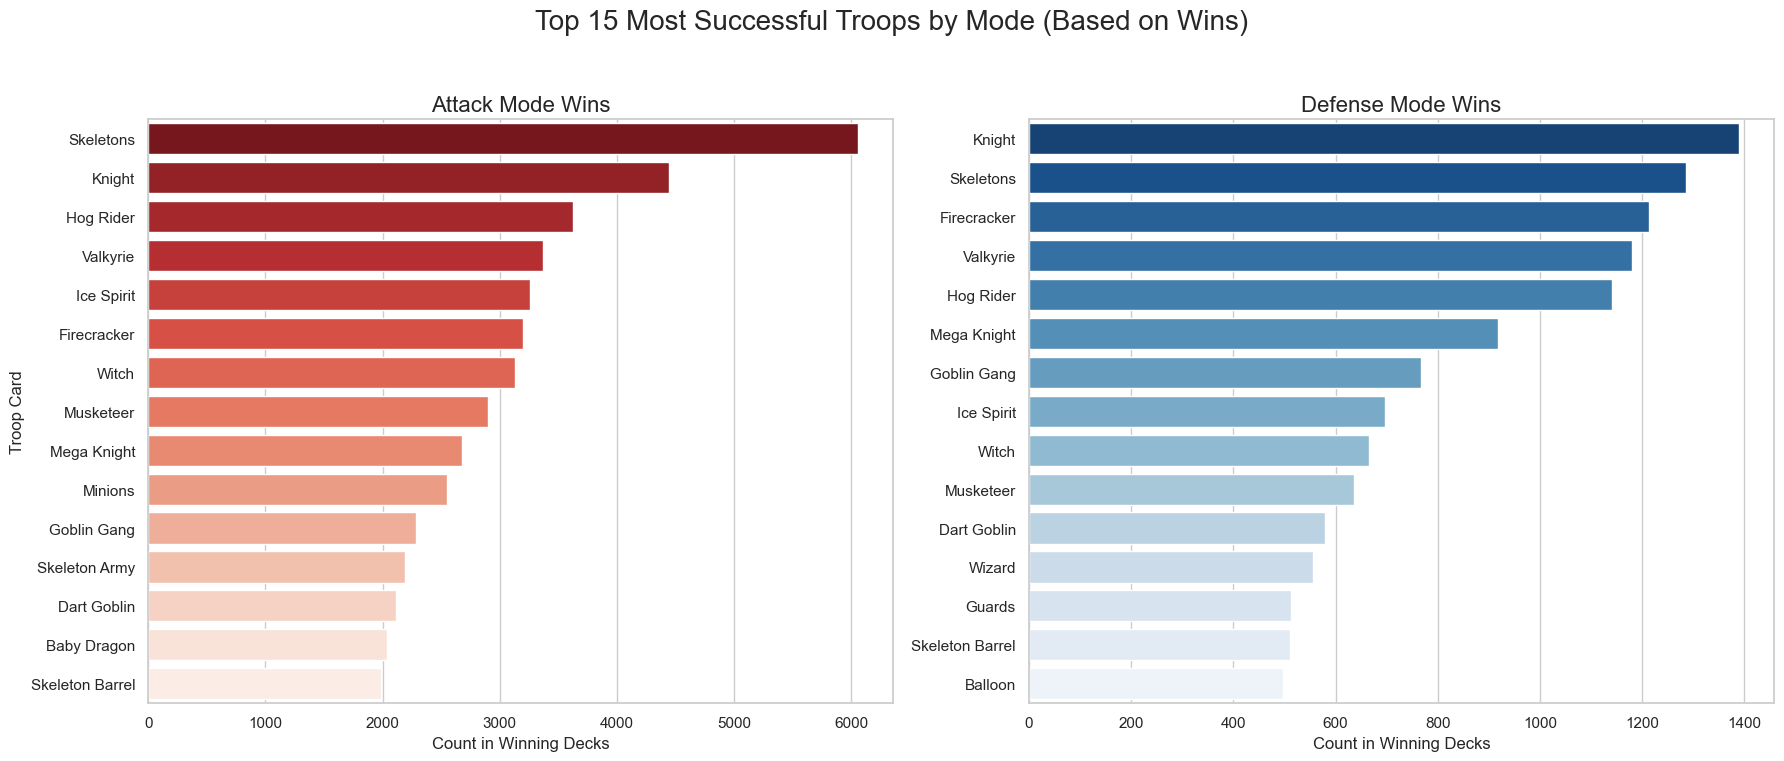

2025-12-10 15:36:15,645 - INFO - Plot saved to c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\analysis\recommended_troop_lists.png


In [45]:
# %%
# --- Parse Cards and Determine Mode ---
logger.info("Parsing 'cards' column and determining modes...")

df['card_list'] = df['cards'].apply(ast.literal_eval)
df['mode_type'] = df.apply(get_mode_type, axis=1)

# Filter only winning decks
df_wins = df[df['winner_flag'] == 1].copy()
logger.info(f"Filtered to {len(df_wins)} winning decks.")

# %%
# --- Count Troops by Mode ---
attack_troop_counts = Counter()
defense_troop_counts = Counter()

for _, row in df_wins.iterrows():
    deck_troops = [card for card in row['card_list'] if card in troop_cards]
    
    if row['mode_type'] == 'Attack':
        attack_troop_counts.update(deck_troops)
    elif row['mode_type'] == 'Defense':
        defense_troop_counts.update(deck_troops)

# %%
# --- Create DataFrames of Top 15 Troops ---
df_attack_troops = pd.DataFrame(attack_troop_counts.most_common(15), 
                                columns=['Troop', 'Frequency']).sort_values('Frequency', ascending=False)
df_defense_troops = pd.DataFrame(defense_troop_counts.most_common(15), 
                                 columns=['Troop', 'Frequency']).sort_values('Frequency', ascending=False)

logger.info(f"Top Attack Troops:\n{df_attack_troops.head(3).to_string()}")
logger.info(f"Top Defense Troops:\n{df_defense_troops.head(3).to_string()}")

df_attack_troops.head(), df_defense_troops.head()


# %%
# --- Plot Visualization ---
logger.info(f"Generating plot... saving to {RECOMMENDED_TROOPS_FILE}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Top 15 Most Successful Troops by Mode (Based on Wins)', fontsize=20)

# Attack Plot
sns.barplot(data=df_attack_troops, x='Frequency', y='Troop', ax=ax1, palette='Reds_r')
ax1.set_title('Attack Mode Wins', fontsize=16)
ax1.set_xlabel('Count in Winning Decks', fontsize=12)
ax1.set_ylabel('Troop Card', fontsize=12)

# Defense Plot
sns.barplot(data=df_defense_troops, x='Frequency', y='Troop', ax=ax2, palette='Blues_r')
ax2.set_title('Defense Mode Wins', fontsize=16)
ax2.set_xlabel('Count in Winning Decks', fontsize=12)
ax2.set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(RECOMMENDED_TROOPS_FILE)
plt.show()

logger.info(f"Plot saved to {RECOMMENDED_TROOPS_FILE}")


# Card Synergy Heatmap Generation
This notebook analyzes the synergy between the most popular core cards (Troops and Buildings) in Clash Royale, based on their co-occurrence in winning decks.
The output is a heatmap that visualizes **pairwise win rates** between the top 20 core cards.


In [46]:
# %%
# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import ast
from itertools import combinations
from collections import defaultdict

# %%
# --- Configuration ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Set plot style
sns.set_theme(style="whitegrid")


In [47]:
# %%
# --- File Paths ---
PROJECT_ROOT = os.path.dirname(os.path.abspath(''))
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
OUTPUT_DIR = os.path.join(PROJECT_ROOT, "analysis")

# Input files
PREPROCESSED_FILE = os.path.join(DATA_DIR, "preprocessed_data.csv")
CARDS_FILE = os.path.join(DATA_DIR, "cards_data.csv")

# Output plot file
SYNERGY_HEATMAP_FILE = os.path.join(OUTPUT_DIR, "synergy_heatmap.png")


In [48]:
# %%
# --- Load Data ---
try:
    logger.info(f"Loading {PREPROCESSED_FILE}...")
    df = pd.read_csv(PREPROCESSED_FILE, usecols=['cards', 'winner_flag'])
    
    logger.info(f"Loading {CARDS_FILE} to filter for core cards...")
    df_cards = pd.read_csv(CARDS_FILE, usecols=['card_name', 'card_type'])
    
    # We only want to see synergy between Troops and Buildings, not Spells
    core_cards = set(df_cards[df_cards['card_type'].isin(['Troop', 'Building'])]['card_name'])
    logger.info(f"Filtered to {len(core_cards)} core cards (Troops/Buildings).")

except FileNotFoundError as e:
    logger.error(f"ERROR: File not found. Missing file: {e.filename}")
    raise
except Exception as e:
    logger.error(f"Unexpected error during loading: {e}", exc_info=True)
    raise

# %%
# --- Parse and Clean Card Lists ---
logger.info("Parsing 'cards' column...")

# Convert string representation of lists into Python lists safely
df['card_list'] = df['cards'].apply(ast.literal_eval)

# Filter out non-core cards (keep only Troops/Buildings)
df['card_list'] = df['card_list'].apply(lambda cl: [card for card in cl if card in core_cards])

# Flatten and find top 20 most common cards
all_cards = [card for deck in df['card_list'] for card in deck]
top_20_cards = pd.Series(all_cards).value_counts().nlargest(20).index.tolist()
logger.info(f"Top 20 core cards selected for heatmap: {top_20_cards}")
top_20_cards


2025-12-10 15:36:25,797 - INFO - Loading c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\data\preprocessed_data.csv...
2025-12-10 15:36:25,951 - INFO - Loading c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\data\cards_data.csv to filter for core cards...
2025-12-10 15:36:25,954 - INFO - Filtered to 114 core cards (Troops/Buildings).
2025-12-10 15:36:25,955 - INFO - Parsing 'cards' column...
2025-12-10 15:36:26,778 - INFO - Top 20 core cards selected for heatmap: ['Skeletons', 'Knight', 'Hog Rider', 'Firecracker', 'Valkyrie', 'Mega Knight', 'Ice Spirit', 'Witch', 'Musketeer', 'Cannon', 'Goblin Gang', 'Tesla', 'Dart Goblin', 'Skeleton Army', 'Minions', 'Skeleton Barrel', 'Electro Wizard', 'Bats', 'Electro Spirit', 'Baby Dragon']


['Skeletons',
 'Knight',
 'Hog Rider',
 'Firecracker',
 'Valkyrie',
 'Mega Knight',
 'Ice Spirit',
 'Witch',
 'Musketeer',
 'Cannon',
 'Goblin Gang',
 'Tesla',
 'Dart Goblin',
 'Skeleton Army',
 'Minions',
 'Skeleton Barrel',
 'Electro Wizard',
 'Bats',
 'Electro Spirit',
 'Baby Dragon']

In [49]:
# %%
# --- Compute Pairwise Win Rates ---
pair_wins = defaultdict(int)
pair_counts = defaultdict(int)

logger.info("Calculating win rates for card pairs... This may take a moment.")

for _, row in df.iterrows():
    deck_cards = set(row['card_list']) & set(top_20_cards)
    for card_a, card_b in combinations(sorted(deck_cards), 2):
        pair = (card_a, card_b)
        pair_counts[pair] += 1
        if row['winner_flag'] == 1:
            pair_wins[pair] += 1


2025-12-10 15:36:29,444 - INFO - Calculating win rates for card pairs... This may take a moment.


In [50]:
# %%
# --- Build Heatmap DataFrame ---
heatmap_data = []
for pair, count in pair_counts.items():
    if count > 10:  # Only include pairs that appeared at least 10 times
        win_rate = pair_wins[pair] / count
        heatmap_data.append({'card_a': pair[0], 'card_b': pair[1], 'win_rate': win_rate})
        # Mirror entry for symmetric heatmap
        heatmap_data.append({'card_a': pair[1], 'card_b': pair[0], 'win_rate': win_rate})

df_heatmap = pd.DataFrame(heatmap_data)

if df_heatmap.empty:
    logger.error("No card pairs found with sufficient data. Aborting plot generation.")
    raise ValueError("Not enough data for heatmap generation.")

logger.info(f"Heatmap data prepared with {len(df_heatmap)} entries.")
df_heatmap.head()


2025-12-10 15:36:32,765 - INFO - Heatmap data prepared with 374 entries.


,card_a,card_b,win_rate
0,Electro Spirit,Skeletons,0.659138
1,Skeletons,Electro Spirit,0.659138
2,Knight,Witch,0.542144
3,Witch,Knight,0.542144
4,Dart Goblin,Ice Spirit,0.564854


In [51]:
# %%
# --- Pivot Data for Heatmap ---
logger.info("Pivoting data for heatmap...")
df_pivot = df_heatmap.pivot_table(index='card_a', columns='card_b', values='win_rate', aggfunc='mean')

# Ensure only top 20 cards are included
df_pivot = df_pivot.reindex(index=top_20_cards, columns=top_20_cards)
df_pivot.head()


2025-12-10 15:36:35,571 - INFO - Pivoting data for heatmap...


card_b,Skeletons,Knight,Hog Rider,Firecracker,Valkyrie,Mega Knight,Ice Spirit,Witch,Musketeer,Cannon,Goblin Gang,Tesla,Dart Goblin,Skeleton Army,Minions,Skeleton Barrel,Electro Wizard,Bats,Electro Spirit,Baby Dragon
card_a,,,,,,,,,,,,,,,,,,,,
Skeletons,NaN,0.650363,0.616044,0.616216,0.553571,0.529032,0.563973,0.555759,0.618094,0.560905,0.644231,0.596032,0.566092,NaN,0.669355,0.673497,0.537954,0.706949,0.659138,0.704918
Knight,0.650363,NaN,0.619089,0.601425,0.531609,0.583584,0.630619,0.542144,0.601957,0.532169,0.580032,0.611720,0.555088,0.585174,0.617456,0.615686,0.548957,0.538255,0.626766,0.634731
Hog Rider,0.616044,0.619089,NaN,0.591574,0.550652,0.532533,0.595373,0.541772,0.562864,0.568635,0.561532,0.622300,0.563272,0.531746,0.625926,0.518750,0.546691,0.538715,0.644573,0.570934
Firecracker,0.616216,0.601425,0.591574,NaN,0.543879,0.544441,0.605303,0.505155,0.575141,0.559227,0.542802,0.592216,0.533811,0.564845,0.546539,0.582011,0.564730,0.513642,0.615245,0.503704
Valkyrie,0.553571,0.531609,0.550652,0.543879,NaN,0.549652,0.565397,0.539461,0.520942,0.562802,0.561491,0.549774,0.562887,0.549020,0.538752,0.554688,0.531915,0.557576,0.530744,0.579399


2025-12-10 15:36:38,228 - INFO - Generating synergy heatmap... saving to c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\analysis\synergy_heatmap.png


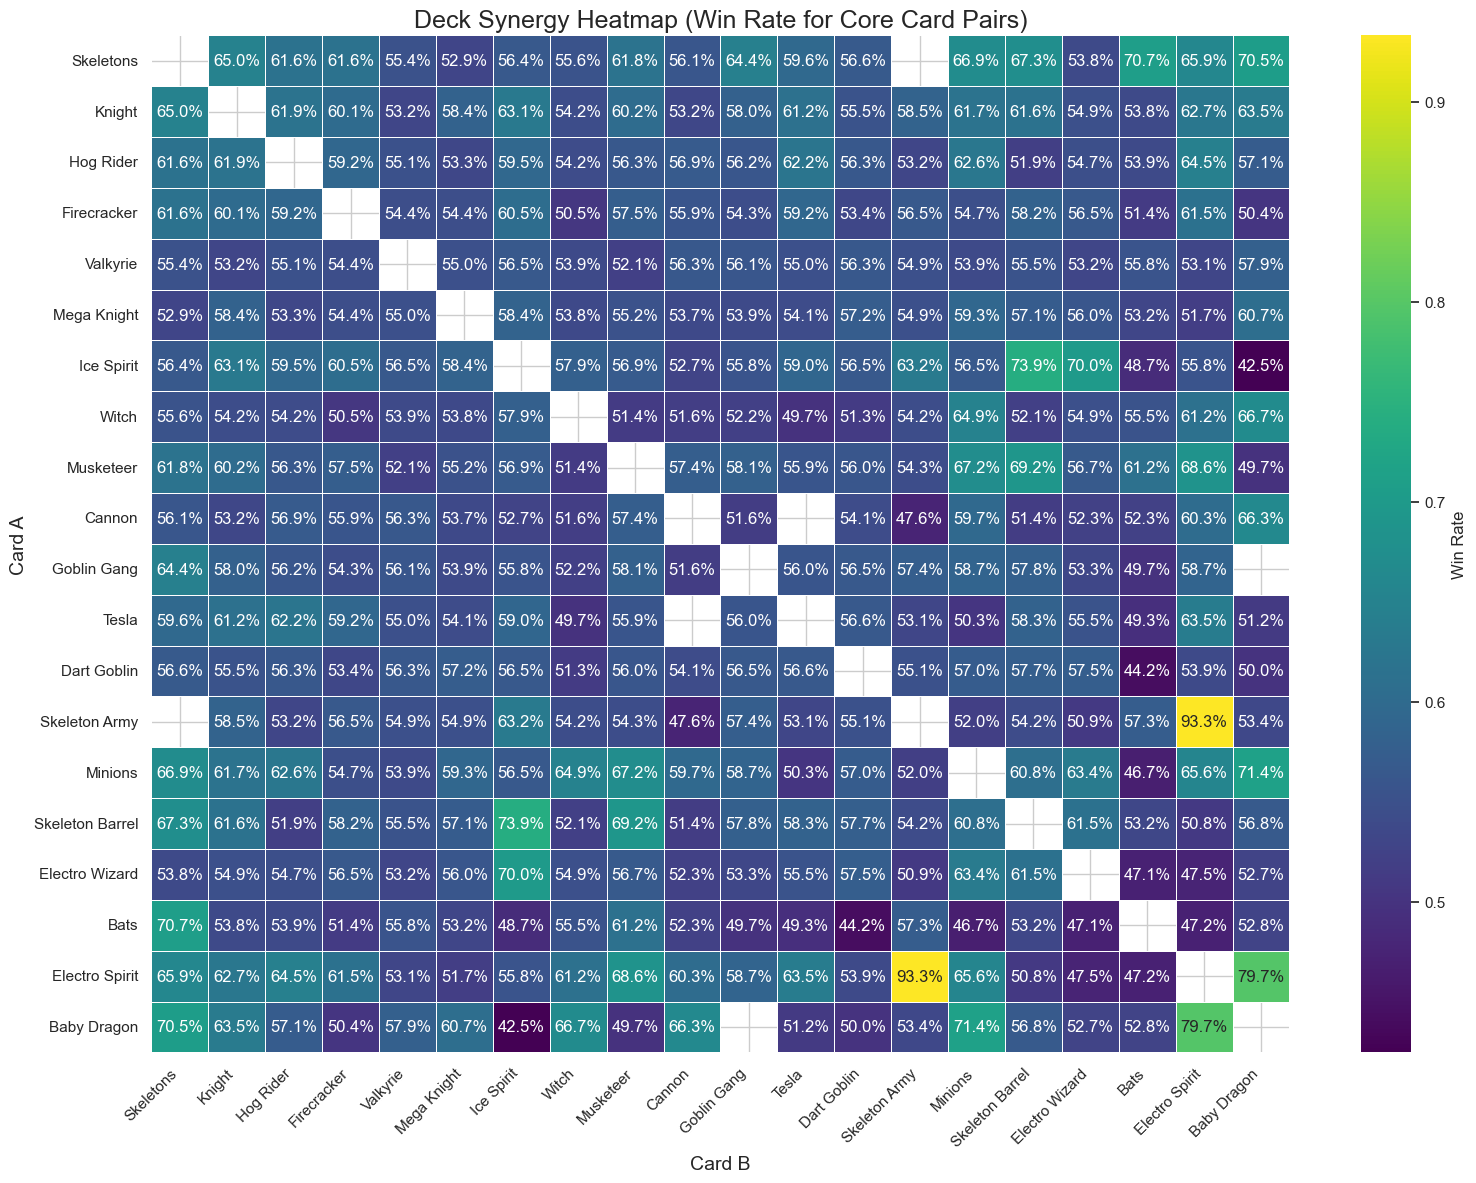

2025-12-10 15:36:39,443 - INFO - Synergy heatmap saved to: c:\Users\Priyanshu\Desktop\Main\Clash Royale Match Recommendation Strategy System\analysis\synergy_heatmap.png


In [52]:
# %%
# --- Plot Synergy Heatmap ---
logger.info(f"Generating synergy heatmap... saving to {SYNERGY_HEATMAP_FILE}")

plt.figure(figsize=(16, 12))
sns.heatmap(
    df_pivot,
    annot=True,
    fmt=".1%",
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={'label': 'Win Rate'}
)
plt.title('Deck Synergy Heatmap (Win Rate for Core Card Pairs)', fontsize=18)
plt.xlabel('Card B', fontsize=14)
plt.ylabel('Card A', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig(SYNERGY_HEATMAP_FILE)
plt.show()

logger.info(f"Synergy heatmap saved to: {SYNERGY_HEATMAP_FILE}")
